<a href="https://colab.research.google.com/github/valentina-diana/COVID-19-Mortality-Prediction-and-Analysis/blob/main/COVID_19_Mortality_Prediction_and_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the necessary libraries
from google.colab import auth
from pyspark.sql import SparkSession
from google.cloud import bigquery
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, year
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Google Cloud authentication
import google.auth
from google.auth import impersonated_credentials
from google.oauth2 import service_account

# Set the path to the JSON authentication file
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/concise-memory-405108-503b46b4a5e7.json"

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Pandemic Data Analysis: COVID-19") \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.29.0") \
    .getOrCreate()

# Define the project, dataset, and table for BigQuery
project_id = "bigquery-public-data"
dataset_id = "dataflix_covid"
table_id = "world_covid"

# Define the required columns
required_columns = [
    "refresh_date",  # The date when the data was updated
    "country_name",   # The name of the country
    "state_name",     # The name of the state
    "confirmed",      # The number of confirmed cases
    "deaths",         # The number of deaths
    "recovered"       # The number of recovered cases
]

# Create the query to select the required data
query = f"""
  SELECT {', '.join(required_columns)}
  FROM `bigquery-public-data.dataflix_covid.world_covid`
  WHERE confirmed IS NOT NULL
    AND deaths IS NOT NULL
    AND recovered IS NOT NULL
    AND country_name IS NOT NULL
    AND country_name != ''
    AND state_name IS NOT NULL
    AND state_name != ''
  LIMIT 1000000
"""

# Read the data using BigQuery
bq_client = bigquery.Client()
query_job = bq_client.query(query)
rows = query_job.result()

# Convert rows to a Pandas DataFrame
pandas_df = rows.to_dataframe()

# Convert the Pandas DataFrame to a PySpark DataFrame
spark_df: DataFrame = spark.createDataFrame(pandas_df)

# Check the years present in the data
year_df = spark_df.withColumn("year", year(col("refresh_date")))


In [ ]:
year_df.select("year").distinct().show()

+----+
|year|
+----+
|2020|
|2021|
+----+



In [ ]:
spark_df.show()

+------------+------------+----------+---------+------+---------+
|refresh_date|country_name|state_name|confirmed|deaths|recovered|
+------------+------------+----------+---------+------+---------+
|  2020-03-08|      Canada|        ON|        1|     0|        1|
|  2020-03-05|      Canada|        ON|       21|     0|        2|
|  2020-03-08|      Canada|        ON|       28|     0|        3|
|  2020-03-08|       Macau|     Macau|       10|     0|       10|
|  2020-03-03|      Canada|    Quebec|        1|     0|        0|
|  2020-03-09|      Canada|    Quebec|        3|     0|        0|
|  2020-03-05|      Canada|    Quebec|        2|     0|        0|
|  2020-03-06|      Canada|    Quebec|        2|     0|        0|
|  2020-03-07|      Canada|    Quebec|        3|     0|        0|
|  2020-03-08|      Canada|    Quebec|        4|     0|        0|
|  2020-03-04|      Canada|    Quebec|        1|     0|        0|
|  2020-03-05|      Canada|   Ontario|        1|     0|        1|
|  2020-03

In [ ]:
# Extract the year column for further analysis
spark_df = spark_df.withColumn("year", year(col("refresh_date")))

In [ ]:
# Convert to Pandas DataFrame for visualization
pandas_df = spark_df.toPandas()

In [ ]:
# We will ensure that the year column is of type int for the chart
pandas_df['year'] = pandas_df['year'].astype(int)

print(pandas_df.head(20))

   refresh_date country_name state_name  confirmed  deaths  recovered  year
0    2020-03-08       Canada         ON          1       0          1  2020
1    2020-03-05       Canada         ON         21       0          2  2020
2    2020-03-08       Canada         ON         28       0          3  2020
3    2020-03-08        Macau      Macau         10       0         10  2020
4    2020-03-03       Canada     Quebec          1       0          0  2020
5    2020-03-09       Canada     Quebec          3       0          0  2020
6    2020-03-05       Canada     Quebec          2       0          0  2020
7    2020-03-06       Canada     Quebec          2       0          0  2020
8    2020-03-07       Canada     Quebec          3       0          0  2020
9    2020-03-08       Canada     Quebec          4       0          0  2020
10   2020-03-04       Canada     Quebec          1       0          0  2020
11   2020-03-05       Canada    Ontario          1       0          1  2020
12   2020-03

 COVID CONFIRMED CASES - for each country and by year

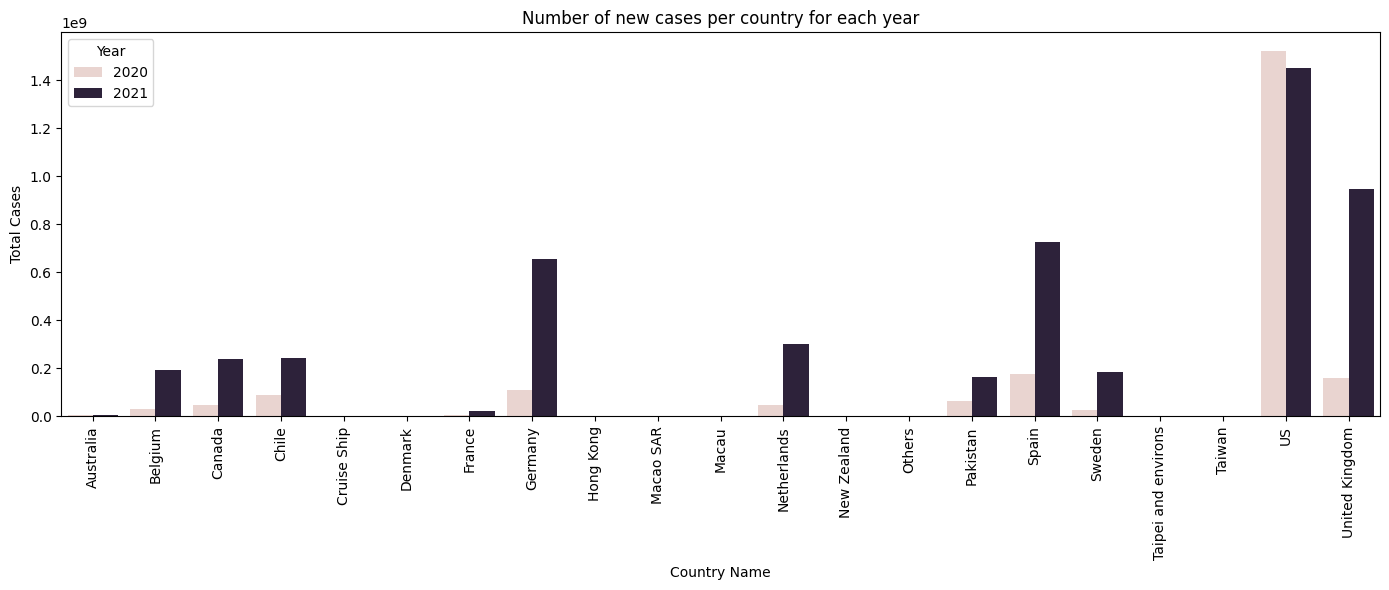

In [ ]:
# Plot 1: Number of cases for each country for each year
plt.figure(figsize=(14, 6))
pandas_grouped_df = pandas_df.groupby(['country_name', 'year']).agg({'confirmed': 'sum'}).reset_index()
sns.barplot(data=pandas_grouped_df, x='country_name', y='confirmed', hue='year', errorbar=None)
plt.title('Number of new cases per country for each year')
plt.xlabel('Country Name')
plt.ylabel('Total Cases')
plt.xticks(rotation=90)
plt.legend(title='Year')
plt.tight_layout()
plt.show()


<ipython-input-11-5db2cfa76ff9>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_3_2020, x='country_name', y='confirmed', palette='viridis')


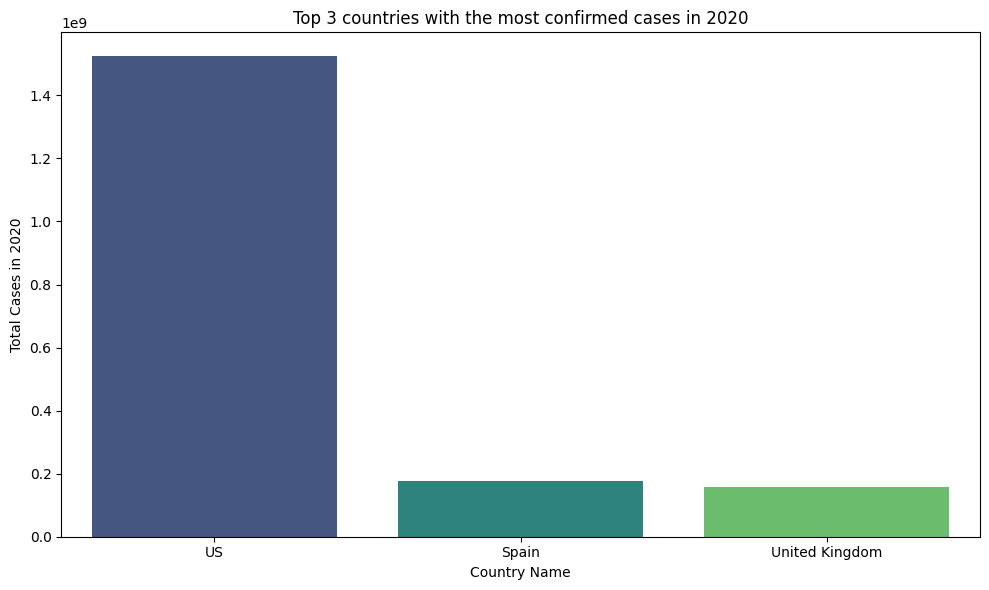

<ipython-input-11-5db2cfa76ff9>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_2020, x='country_name', y='confirmed', palette='viridis')


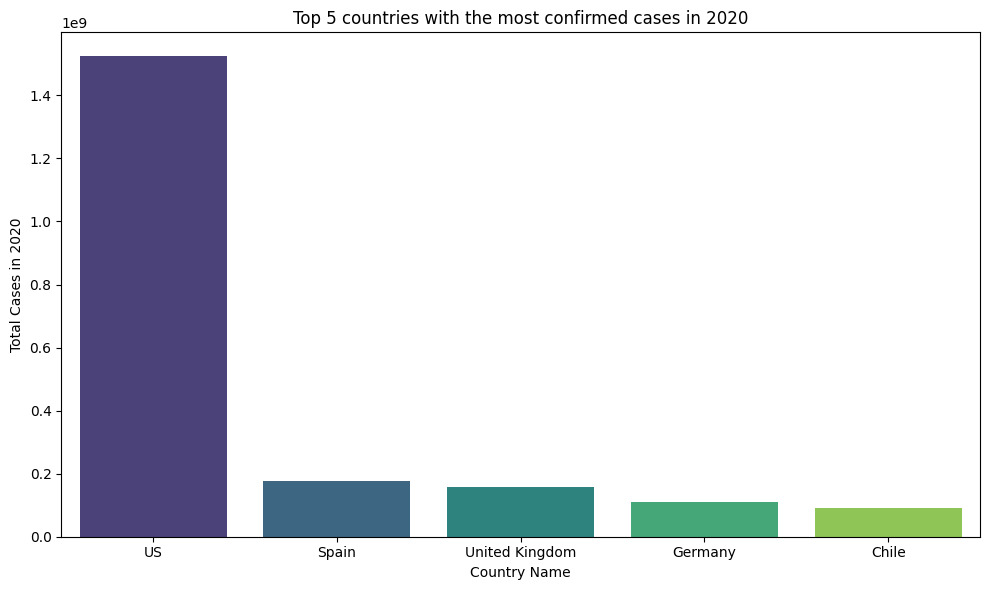

In [ ]:
# Plot 1.1: Top 3 countries with the most COVID cases in 2020
if 'confirmed' in pandas_grouped_df.columns:
    top_3_2020 = pandas_grouped_df[pandas_grouped_df['year'] == 2020].nlargest(3, 'confirmed')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_3_2020, x='country_name', y='confirmed', palette='viridis')
    plt.title('Top 3 countries with the most confirmed cases in 2020')
    plt.xlabel('Country Name')
    plt.ylabel('Total Cases in 2020')
    plt.tight_layout()
    plt.show()

# Plot 1.2: Top 5 countries with the most COVID cases in 2020
if 'confirmed' in pandas_grouped_df.columns:
    top_5_2020 = pandas_grouped_df[pandas_grouped_df['year'] == 2020].nlargest(5, 'confirmed')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_5_2020, x='country_name', y='confirmed', palette='viridis')
    plt.title('Top 5 countries with the most confirmed cases in 2020')
    plt.xlabel('Country Name')
    plt.ylabel('Total Cases in 2020')
    plt.tight_layout()
    plt.show()


<ipython-input-12-d4a2122e7bf5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_3_2021, x='country_name', y='confirmed', palette='viridis')


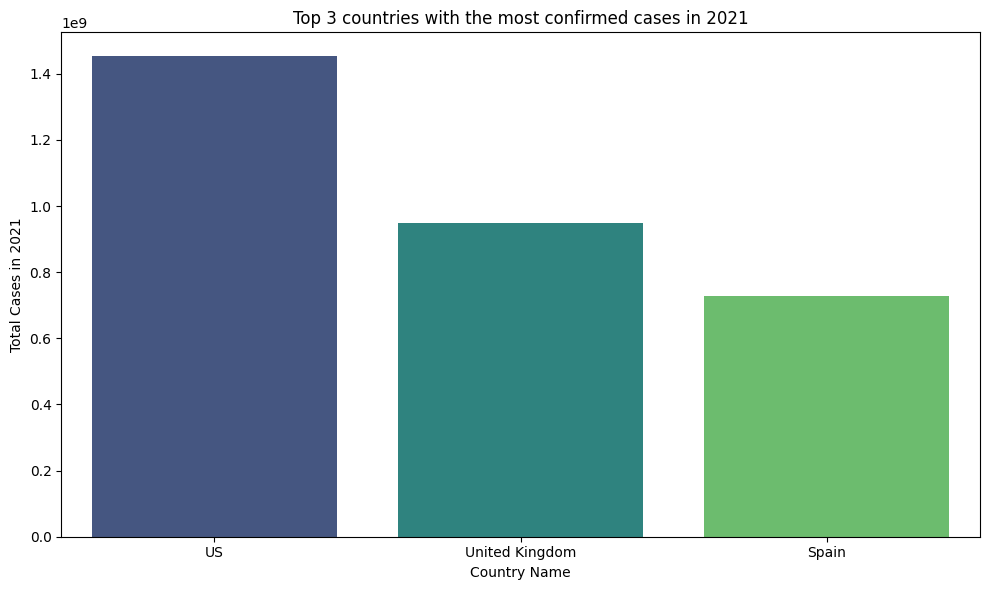

<ipython-input-12-d4a2122e7bf5>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_2021, x='country_name', y='confirmed', palette='viridis')


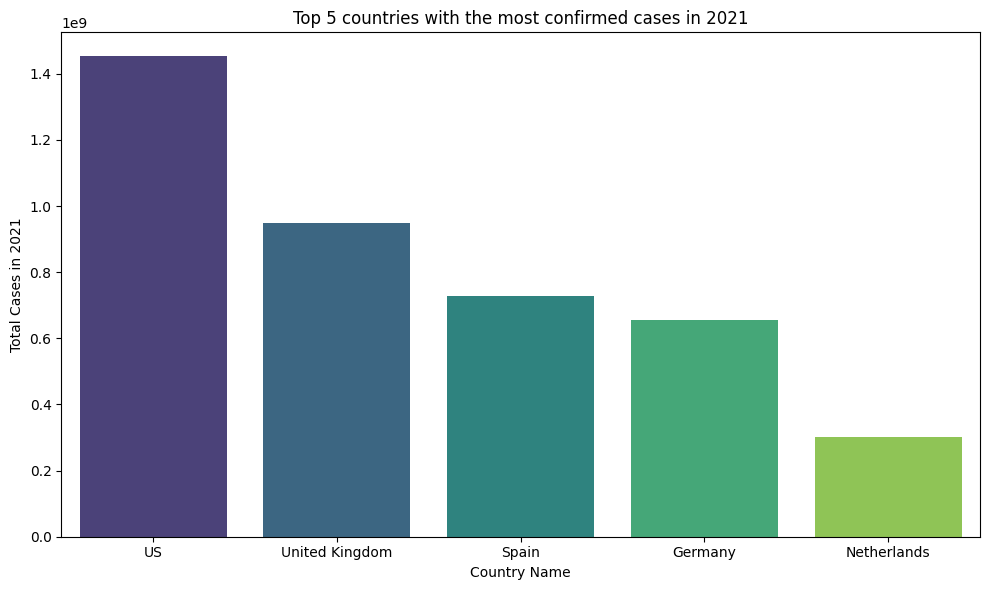

In [ ]:
# Plot 1.3: Top 3 countries with the most COVID cases in 2021
if 'confirmed' in pandas_grouped_df.columns:
    top_3_2021 = pandas_grouped_df[pandas_grouped_df['year'] == 2021].nlargest(3, 'confirmed')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_3_2021, x='country_name', y='confirmed', palette='viridis')
    plt.title('Top 3 countries with the most confirmed cases in 2021')
    plt.xlabel('Country Name')
    plt.ylabel('Total Cases in 2021')
    plt.tight_layout()
    plt.show()

# Plot 1.4: Top 5 countries with the most COVID cases in 2021
if 'confirmed' in pandas_grouped_df.columns:
    top_5_2021 = pandas_grouped_df[pandas_grouped_df['year'] == 2021].nlargest(5, 'confirmed')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_5_2021, x='country_name', y='confirmed', palette='viridis')
    plt.title('Top 5 countries with the most confirmed cases in 2021')
    plt.xlabel('Country Name')
    plt.ylabel('Total Cases in 2021')
    plt.tight_layout()
    plt.show()


THE NUMBER OF DEATHS DUE TO COVID - for each country and by year

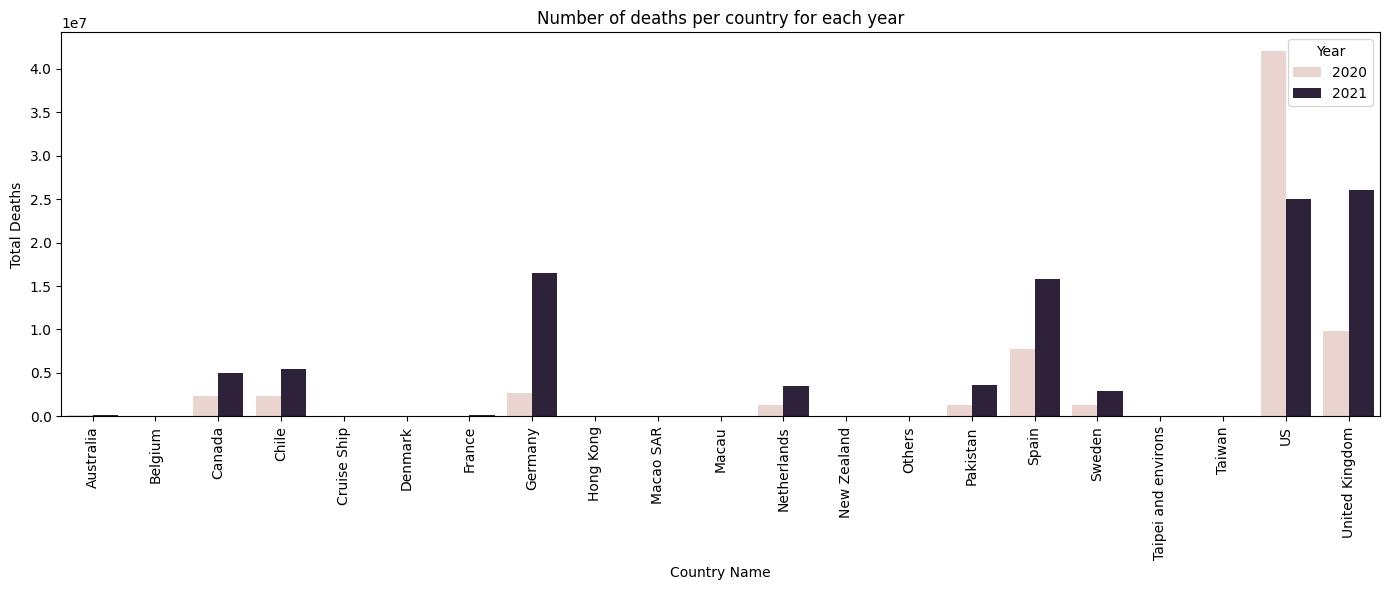

In [ ]:
# Plot 2: Number of deaths for each country in each year
plt.figure(figsize=(14, 6))
pandas_grouped_df = pandas_df.groupby(['country_name', 'year']).agg({'deaths': 'sum'}).reset_index()
sns.barplot(data=pandas_grouped_df, x='country_name', y='deaths', hue='year', errorbar=None)
plt.title('Number of deaths per country for each year')
plt.xlabel('Country Name')
plt.ylabel('Total Deaths')
plt.xticks(rotation=90)
plt.legend(title='Year')
plt.tight_layout()
plt.show()


<ipython-input-14-2f44191a4309>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_3_2020, x='country_name', y='deaths', palette='viridis')


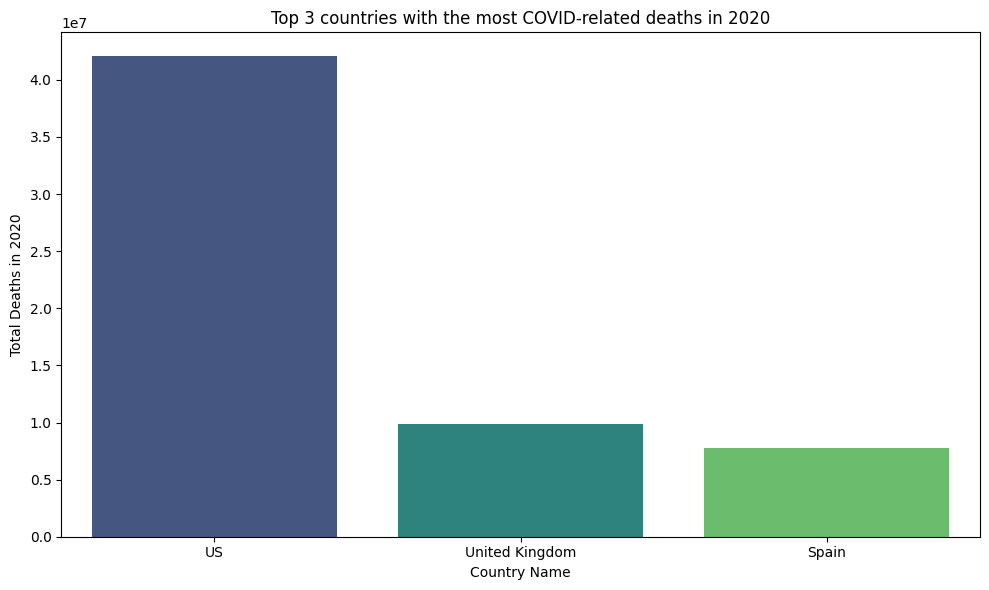

<ipython-input-14-2f44191a4309>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_2020, x='country_name', y='deaths', palette='viridis')


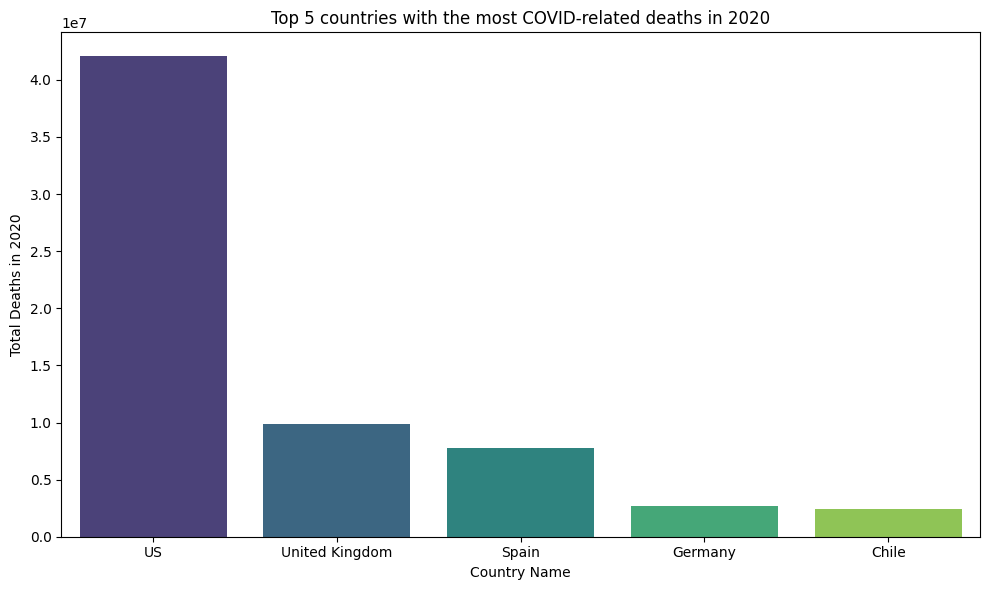

In [ ]:
# Plot 2.1: Top 3 countries with the most COVID-related deaths in 2020
if 'deaths' in pandas_grouped_df.columns:
    top_3_2020 = pandas_grouped_df[pandas_grouped_df['year'] == 2020].nlargest(3, 'deaths')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_3_2020, x='country_name', y='deaths', palette='viridis')
    plt.title('Top 3 countries with the most COVID-related deaths in 2020')
    plt.xlabel('Country Name')
    plt.ylabel('Total Deaths in 2020')
    plt.tight_layout()
    plt.show()

# Plot 2.2: Top 5 countries with the most COVID-related deaths in 2020
if 'deaths' in pandas_grouped_df.columns:
    top_5_2020 = pandas_grouped_df[pandas_grouped_df['year'] == 2020].nlargest(5, 'deaths')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_5_2020, x='country_name', y='deaths', palette='viridis')
    plt.title('Top 5 countries with the most COVID-related deaths in 2020')
    plt.xlabel('Country Name')
    plt.ylabel('Total Deaths in 2020')
    plt.tight_layout()
    plt.show()


<ipython-input-15-4728a0f46835>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_3_2021, x='country_name', y='deaths', palette='viridis')


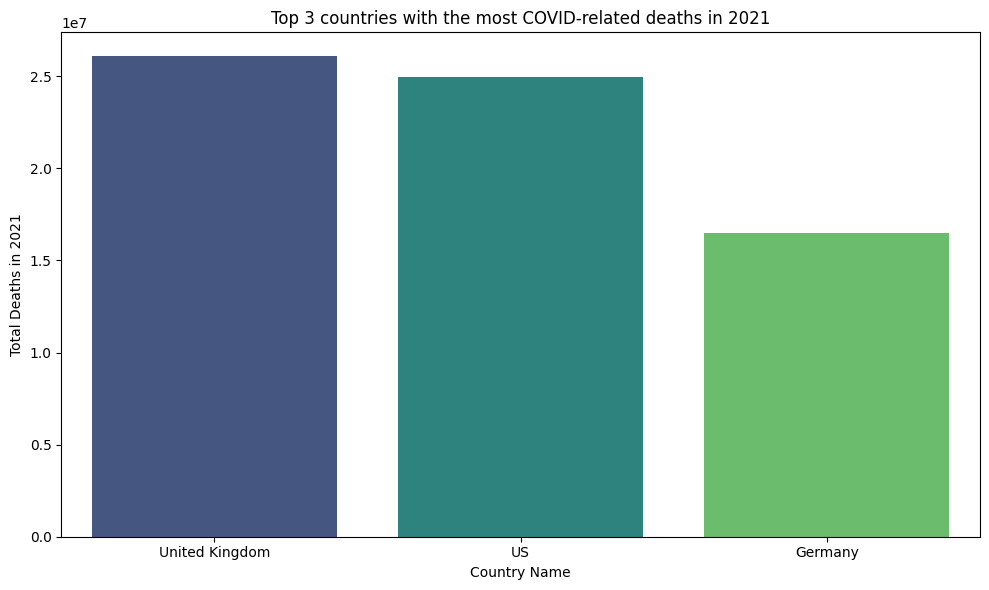

<ipython-input-15-4728a0f46835>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_2021, x='country_name', y='deaths', palette='viridis')


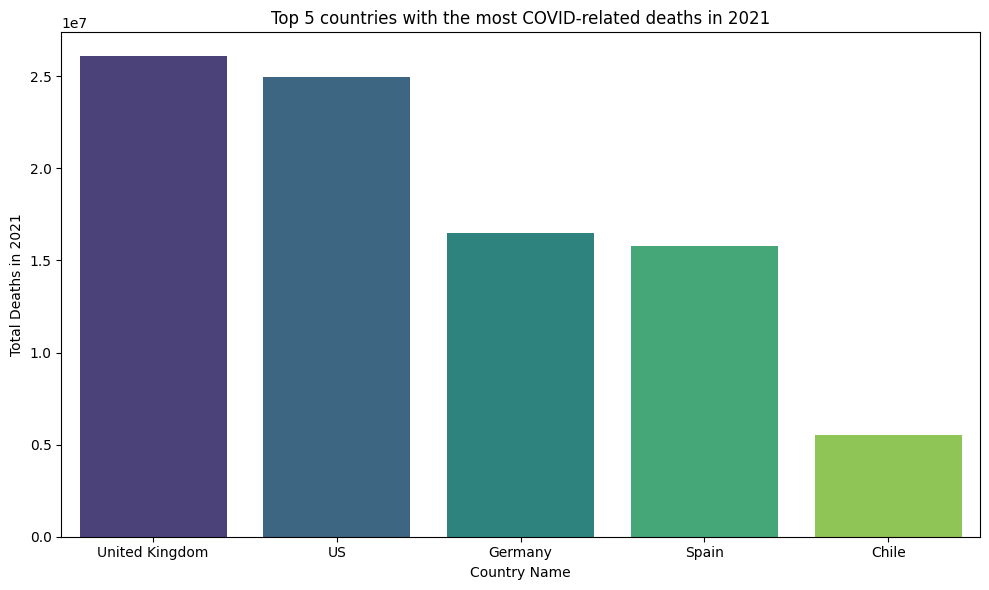

In [ ]:
# Plot 2.3: Top 3 countries with the most COVID-related deaths in 2021
if 'deaths' in pandas_grouped_df.columns:
    top_3_2021 = pandas_grouped_df[pandas_grouped_df['year'] == 2021].nlargest(3, 'deaths')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_3_2021, x='country_name', y='deaths', palette='viridis')
    plt.title('Top 3 countries with the most COVID-related deaths in 2021')
    plt.xlabel('Country Name')
    plt.ylabel('Total Deaths in 2021')
    plt.tight_layout()
    plt.show()

# Plot 2.4: Top 5 countries with the most COVID-related deaths in 2021
if 'deaths' in pandas_grouped_df.columns:
    top_5_2021 = pandas_grouped_df[pandas_grouped_df['year'] == 2021].nlargest(5, 'deaths')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_5_2021, x='country_name', y='deaths', palette='viridis')
    plt.title('Top 5 countries with the most COVID-related deaths in 2021')
    plt.xlabel('Country Name')
    plt.ylabel('Total Deaths in 2021')
    plt.tight_layout()
    plt.show()



THE NUMBER OF RECOVERIES FOLLOWING COVID - for each country and per year

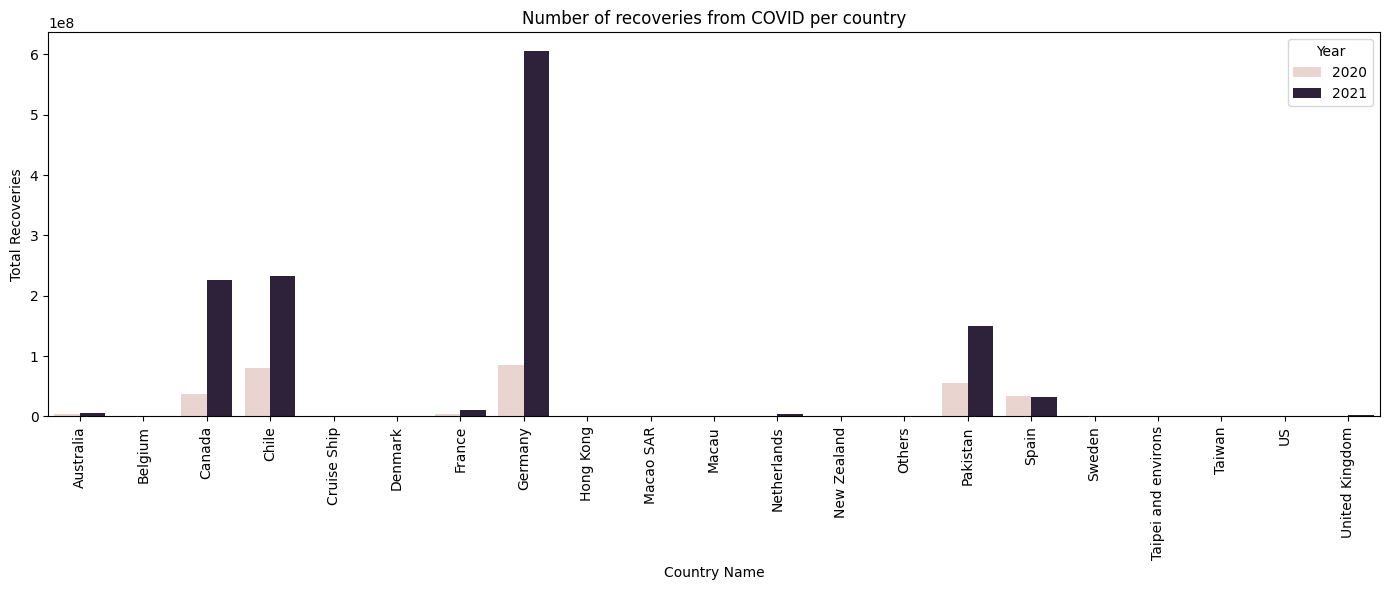

In [ ]:
# Plot 3: Number of recoveries from COVID for each country per year
plt.figure(figsize=(14, 6))
pandas_grouped_df = pandas_df.groupby(['country_name', 'year']).agg({'recovered': 'sum'}).reset_index()
sns.barplot(data=pandas_grouped_df, x='country_name', y='recovered', hue='year', errorbar=None)
plt.title('Number of recoveries from COVID per country')
plt.xlabel('Country Name')
plt.ylabel('Total Recoveries')
plt.xticks(rotation=90)
plt.legend(title='Year')
plt.tight_layout()
plt.show()


<ipython-input-19-29903285f8d8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_3_recovered_2020, x='country_name', y='recovered', palette='viridis')


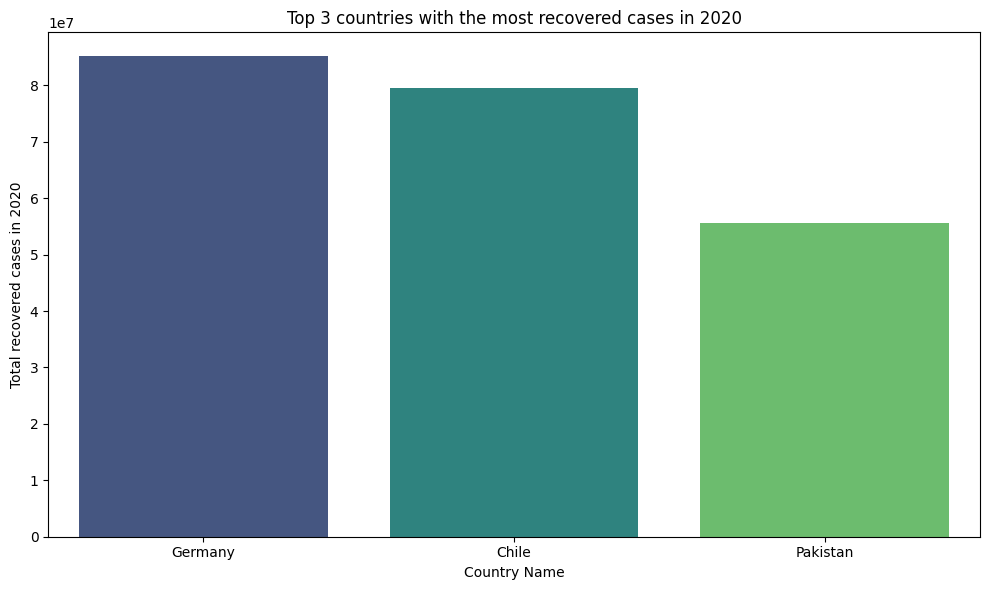

<ipython-input-19-29903285f8d8>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_recovered_2020, x='country_name', y='recovered', palette='viridis')


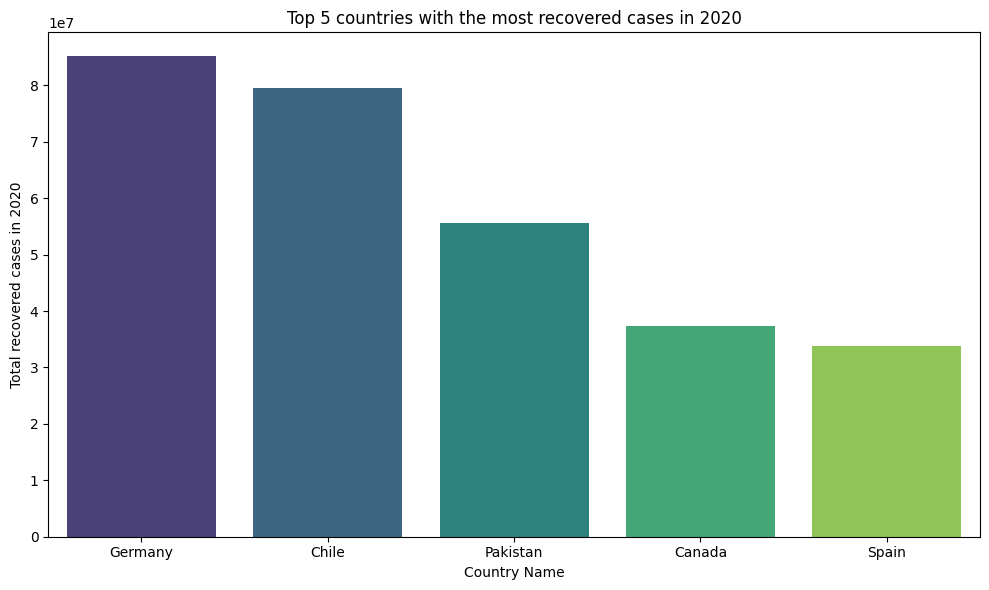

In [ ]:
# Plot 3.1: Top 3 countries with the most recovered cases in 2020
if 'recovered' in pandas_grouped_df.columns:
    top_3_recovered_2020 = pandas_grouped_df[pandas_grouped_df['year'] == 2020].nlargest(3, 'recovered')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_3_recovered_2020, x='country_name', y='recovered', palette='viridis')
    plt.title('Top 3 countries with the most recovered cases in 2020')
    plt.xlabel('Country Name')
    plt.ylabel('Total recovered cases in 2020')
    plt.tight_layout()
    plt.show()

# Plot 3.2: Top 5 countries with the most recovered cases in 2020
if 'recovered' in pandas_grouped_df.columns:
    top_5_recovered_2020 = pandas_grouped_df[pandas_grouped_df['year'] == 2020].nlargest(5, 'recovered')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_5_recovered_2020, x='country_name', y='recovered', palette='viridis')
    plt.title('Top 5 countries with the most recovered cases in 2020')
    plt.xlabel('Country Name')
    plt.ylabel('Total recovered cases in 2020')
    plt.tight_layout()
    plt.show()


<ipython-input-20-2adf4003328a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_3_recovered_2021, x='country_name', y='recovered', palette='viridis')


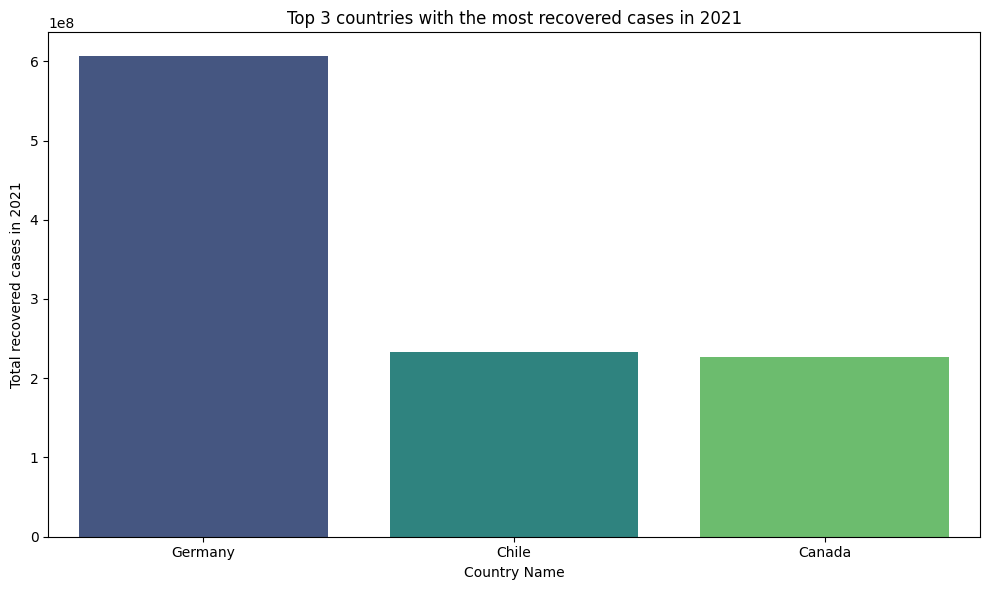

<ipython-input-20-2adf4003328a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_recovered_2021, x='country_name', y='recovered', palette='viridis')


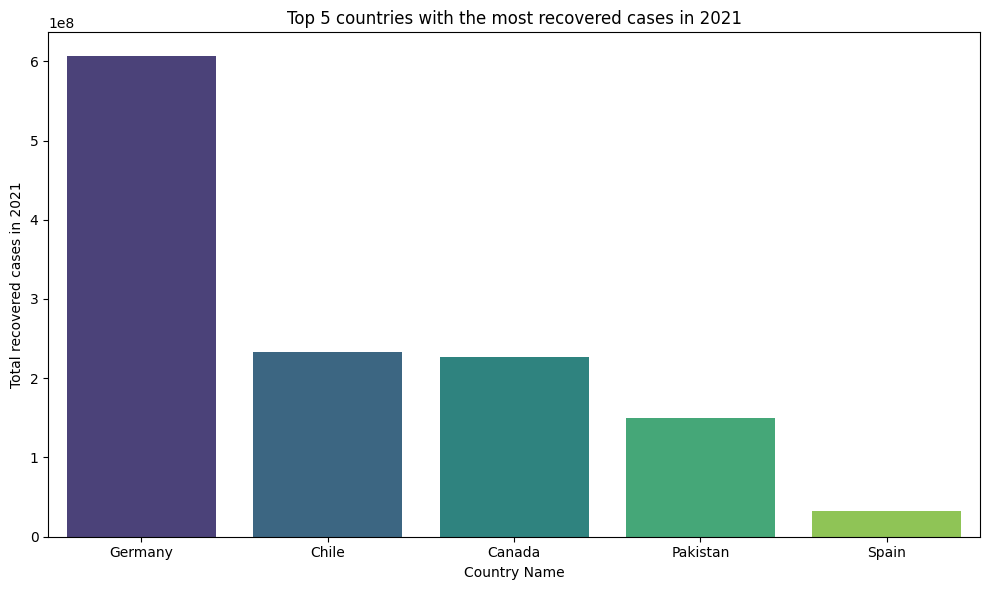

In [ ]:
# Plot 3.3: Top 3 countries with the most recovered cases in 2021
if 'recovered' in pandas_grouped_df.columns:
    top_3_recovered_2021 = pandas_grouped_df[pandas_grouped_df['year'] == 2021].nlargest(3, 'recovered')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_3_recovered_2021, x='country_name', y='recovered', palette='viridis')
    plt.title('Top 3 countries with the most recovered cases in 2021')
    plt.xlabel('Country Name')
    plt.ylabel('Total recovered cases in 2021')
    plt.tight_layout()
    plt.show()

# Plot 3.4: Top 5 countries with the most recovered cases in 2021
if 'recovered' in pandas_grouped_df.columns:
    top_5_recovered_2021 = pandas_grouped_df[pandas_grouped_df['year'] == 2021].nlargest(5, 'recovered')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_5_recovered_2021, x='country_name', y='recovered', palette='viridis')
    plt.title('Top 5 countries with the most recovered cases in 2021')
    plt.xlabel('Country Name')
    plt.ylabel('Total recovered cases in 2021')
    plt.tight_layout()
    plt.show()


ANALYSIS OF RECOVERED CASES OF COVID IN COMPARISON WITH CONFIRMED CASES AND DEATHS

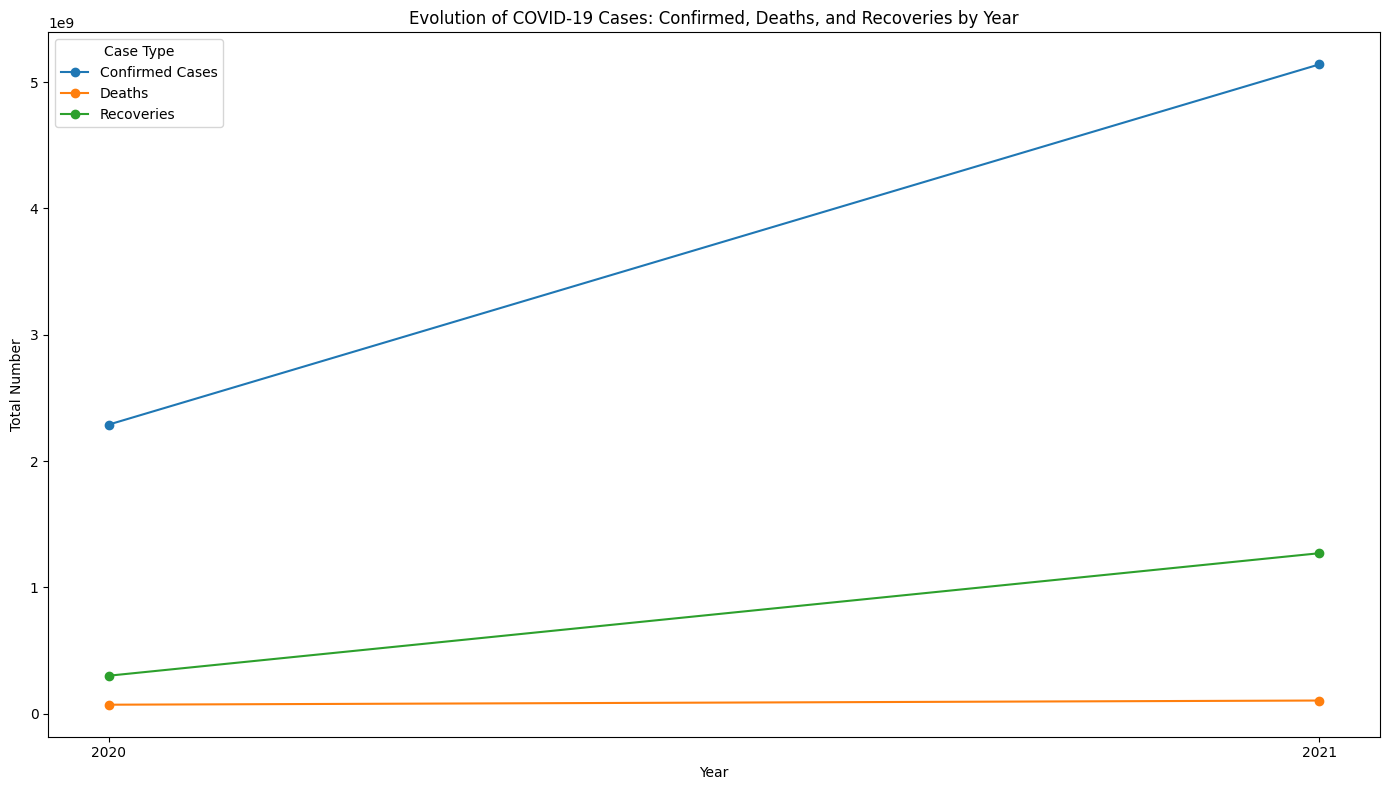

In [ ]:
# Line Plot: Evolution of COVID-19 recovery cases compared to confirmed cases and deaths
plt.figure(figsize=(14, 8))

# Grouping data to get the sum of confirmed cases, deaths, and recoveries by year
evolution_grouped_df = pandas_df.groupby(['year']).agg({
    'confirmed': 'sum',          # Confirmed cases
    'deaths': 'sum',             # Deaths
    'recovered': 'sum'           # Recoveries
}).reset_index()

# Plotting confirmed cases
plt.plot(evolution_grouped_df['year'].astype(int), evolution_grouped_df['confirmed'], marker='o', label='Confirmed Cases')

# Plotting deaths
plt.plot(evolution_grouped_df['year'].astype(int), evolution_grouped_df['deaths'], marker='o', label='Deaths')

# Plotting recoveries
plt.plot(evolution_grouped_df['year'].astype(int), evolution_grouped_df['recovered'], marker='o', label='Recoveries')

# Setting labels and title
plt.title('Evolution of COVID-19 Cases: Confirmed, Deaths, and Recoveries by Year')
plt.xlabel('Year')
plt.ylabel('Total Number')
plt.xticks(ticks=evolution_grouped_df['year'].astype(int), labels=evolution_grouped_df['year'].astype(int))
plt.legend(title='Case Type')
plt.tight_layout()
plt.show()


In [ ]:
# Defining the required columns
required_columns = [
    "refresh_date",  # The date when the data was updated
    "country_name",   # The name of the country
    "state_name",     # The name of the state
    "confirmed",      # The number of confirmed cases
    "deaths",         # The number of deaths
    "recovered"       # The number of recovered cases
]

# Creating the query to select the necessary data
query = f"""
  SELECT {', '.join(required_columns)}
  FROM `bigquery-public-data.dataflix_covid.world_covid`
  WHERE confirmed IS NOT NULL
    AND deaths IS NOT NULL
    AND recovered IS NOT NULL
    AND country_name IS NOT NULL
    AND country_name != ''
    AND state_name IS NOT NULL
    AND state_name != ''
  LIMIT 1000000
"""

# Reading the data using BigQuery
bq_client = bigquery.Client()
query_job = bq_client.query(query)
rows = query_job.result()

# Converting the rows to a Pandas DataFrame
pandas_df = rows.to_dataframe()

# Converting the Pandas DataFrame to a PySpark DataFrame
spark_df: DataFrame = spark.createDataFrame(pandas_df)

# Checking the years present in the data
year_df = spark_df.withColumn("year", year(col("refresh_date")))


I extracted from the refresh_date column - the year, month and day in separate columns

In [ ]:
from pyspark.sql.functions import col, year, month, day

# Extract the year, month, and day from the `refresh_date` column
spark_df = spark_df.withColumn("year", year(col("refresh_date")))
spark_df = spark_df.withColumn("month", month(col("refresh_date")))
spark_df = spark_df.withColumn("day", day(col("refresh_date")))

# Convert back to Pandas for visualization
pandas_df = spark_df.toPandas()
pandas_df['year'] = pandas_df['year'].astype(int)  # Ensure `year` is an integer

# Check the extracted data
print(pandas_df[['refresh_date', 'year', 'month', 'day']].head())  # Display the first rows for verification


  refresh_date  year  month  day
0   2020-03-08  2020      3    8
1   2020-03-05  2020      3    5
2   2020-03-08  2020      3    8
3   2020-03-08  2020      3    8
4   2020-03-03  2020      3    3


MONTHLY ANALYSIS for confirmed cases, number of recoveries and deaths

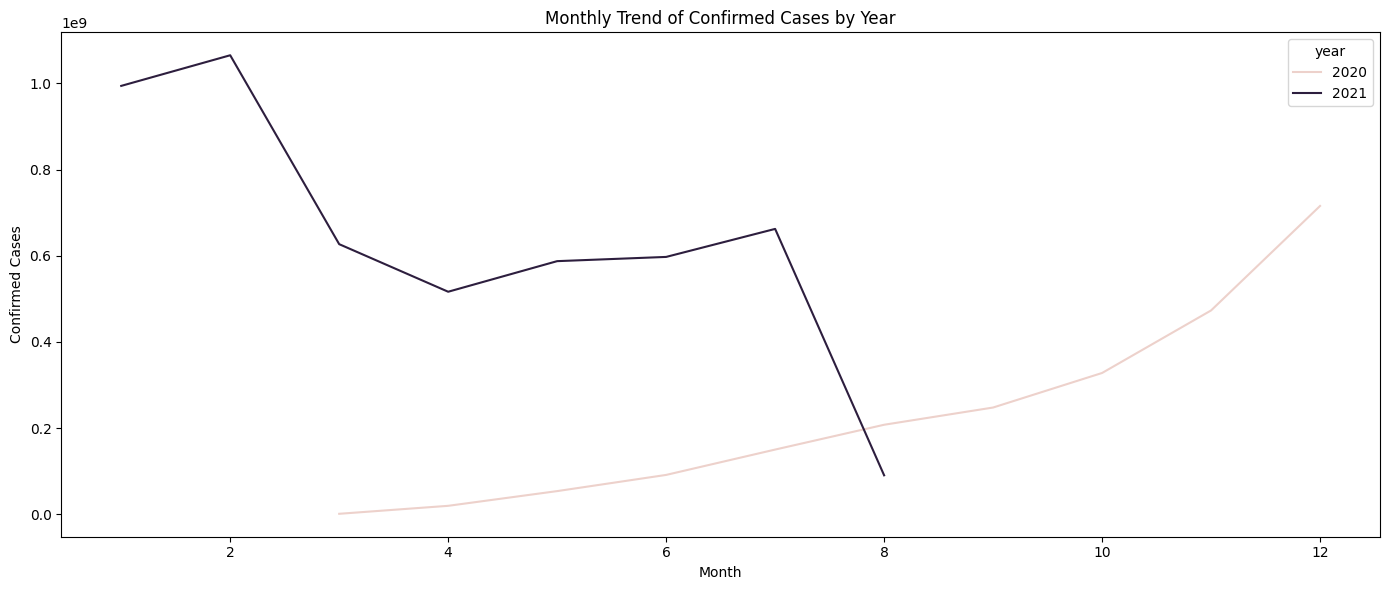

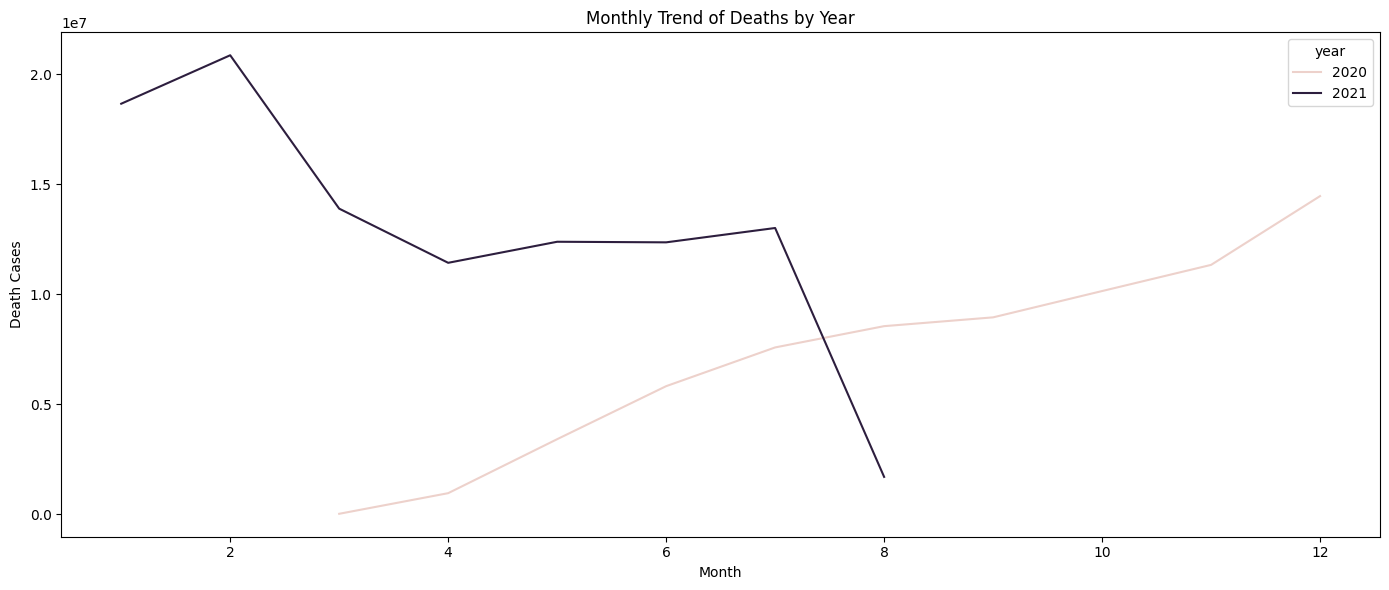

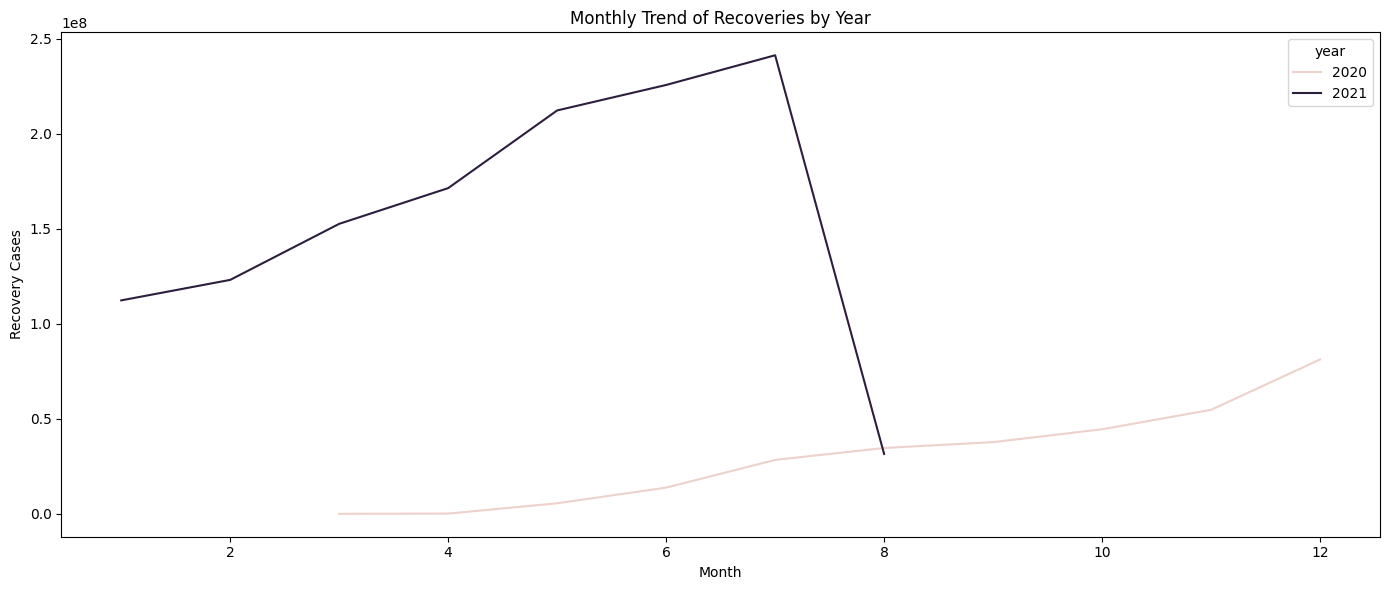

In [ ]:
# Monthly analysis for confirmed cases, deaths, and recoveries
monthly_trends_df = pandas_df.groupby(['year', 'month']).agg({
    'confirmed': 'sum',
    'deaths': 'sum',
    'recovered': 'sum'
}).reset_index()

# Plotting the monthly trend for confirmed cases
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_trends_df, x='month', y='confirmed', hue='year')
plt.title('Monthly Trend of Confirmed Cases by Year')
plt.xlabel('Month')
plt.ylabel('Confirmed Cases')
plt.tight_layout()
plt.show()

# Plotting the monthly trend for deaths
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_trends_df, x='month', y='deaths', hue='year')
plt.title('Monthly Trend of Deaths by Year')
plt.xlabel('Month')
plt.ylabel('Death Cases')
plt.tight_layout()
plt.show()

# Plotting the monthly trend for recoveries
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_trends_df, x='month', y='recovered', hue='year')
plt.title('Monthly Trend of Recoveries by Year')
plt.xlabel('Month')
plt.ylabel('Recovery Cases')
plt.tight_layout()
plt.show()


In [ ]:
"""
import numpy as np

# Check how many data points we have for each year
print(pandas_df['year'].value_counts())

# Check the data for the year 2020
print(pandas_df[pandas_df['year'] == 2020])

# Check for null values in the relevant columns
print(pandas_df[['confirmed', 'recovered', 'deaths']].isnull().sum())

# Calculate the recovery and mortality rates
pandas_df['recovery_rate'] = (pandas_df['recovered'] / pandas_df['confirmed']).replace([np.inf, -np.inf], np.nan) * 100
pandas_df['mortality_rate'] = (pandas_df['deaths'] / pandas_df['confirmed']).replace([np.inf, -np.inf], np.nan) * 100

# Recheck if we have correct data for rates
print(pandas_df[['year', 'recovery_rate', 'mortality_rate']].dropna().groupby('year').mean())




year
2020    789468
2021    210532
Name: count, dtype: int64
       refresh_date country_name    state_name  confirmed  deaths  recovered  \
0        2020-03-08       Canada            ON          1       0          1   
1        2020-03-05       Canada            ON         21       0          2   
2        2020-03-08       Canada            ON         28       0          3   
3        2020-03-08        Macau         Macau         10       0         10   
4        2020-03-03       Canada        Quebec          1       0          0   
...             ...          ...           ...        ...     ...        ...   
999995   2020-10-29           US  Pennsylvania        148       2          0   
999996   2020-10-30           US  Pennsylvania        157       2          0   
999997   2020-10-31           US  Pennsylvania        158       2          0   
999998   2020-11-01           US  Pennsylvania        162       2          0   
999999   2020-11-02           US  Pennsylvania        165  


RECOVERY/DEATH RATE per year

<ipython-input-28-e84483538f0c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=recovery_mortality_df, x='year', y='recovery_rate', palette='viridis')


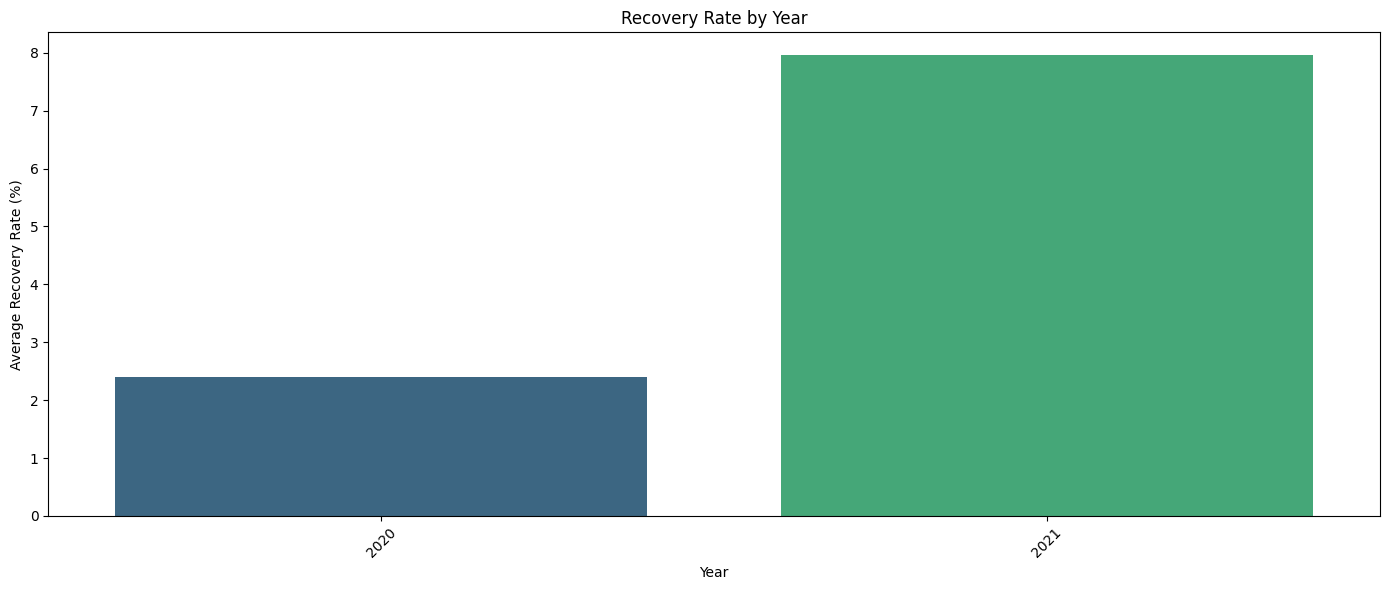

<ipython-input-28-e84483538f0c>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=recovery_mortality_df, x='year', y='mortality_rate', palette='viridis')


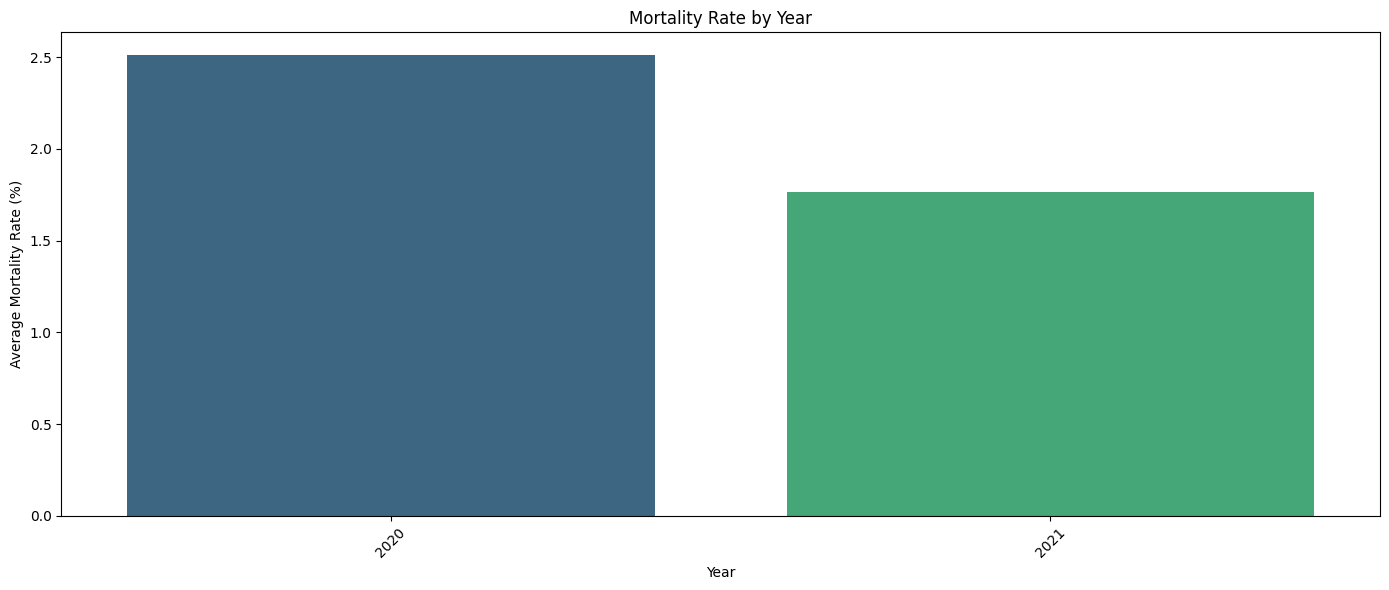

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate recovery and mortality rates
pandas_df['recovery_rate'] = (pandas_df['recovered'] / pandas_df['confirmed']).replace([np.inf, -np.inf], np.nan) * 100
pandas_df['mortality_rate'] = (pandas_df['deaths'] / pandas_df['confirmed']).replace([np.inf, -np.inf], np.nan) * 100

# Group by year and calculate the average recovery rate and mortality rate
recovery_mortality_df = pandas_df.groupby(['year']).agg({
    'recovery_rate': 'mean',
    'mortality_rate': 'mean'
}).reset_index()

# Bar plot for recovery rate
plt.figure(figsize=(14, 6))
sns.barplot(data=recovery_mortality_df, x='year', y='recovery_rate', palette='viridis')
plt.title('Recovery Rate by Year')
plt.xlabel('Year')
plt.ylabel('Average Recovery Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot for mortality rate
plt.figure(figsize=(14, 6))
sns.barplot(data=recovery_mortality_df, x='year', y='mortality_rate', palette='viridis')
plt.title('Mortality Rate by Year')
plt.xlabel('Year')
plt.ylabel('Average Mortality Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


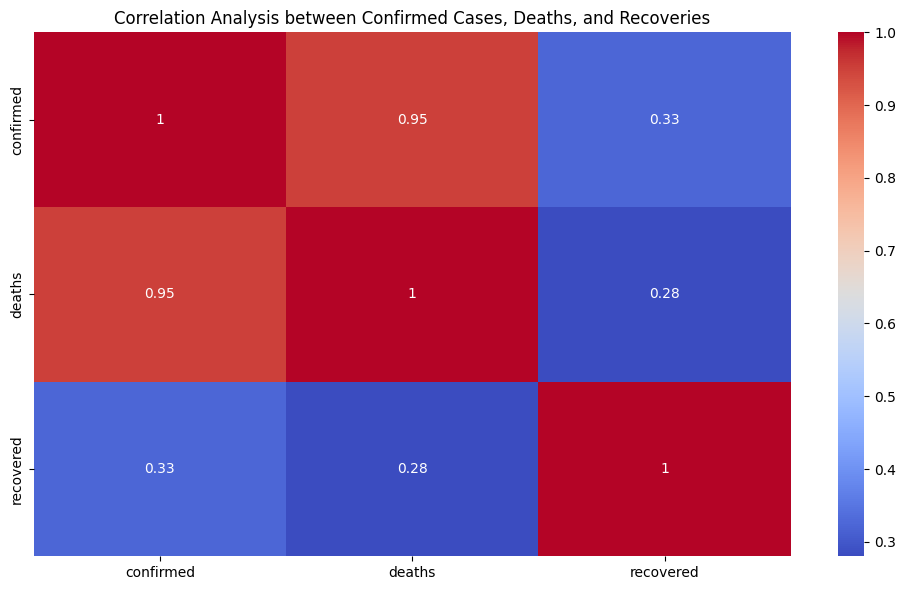

In [ ]:
# Correlation analysis between confirmed cases, deaths, and recoveries
correlation_df = pandas_df[['confirmed', 'deaths', 'recovered']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm')
plt.title('Correlation Analysis between Confirmed Cases, Deaths, and Recoveries')
plt.tight_layout()
plt.show()


MORTALITY RATE and RECOVERY by COUNTRY

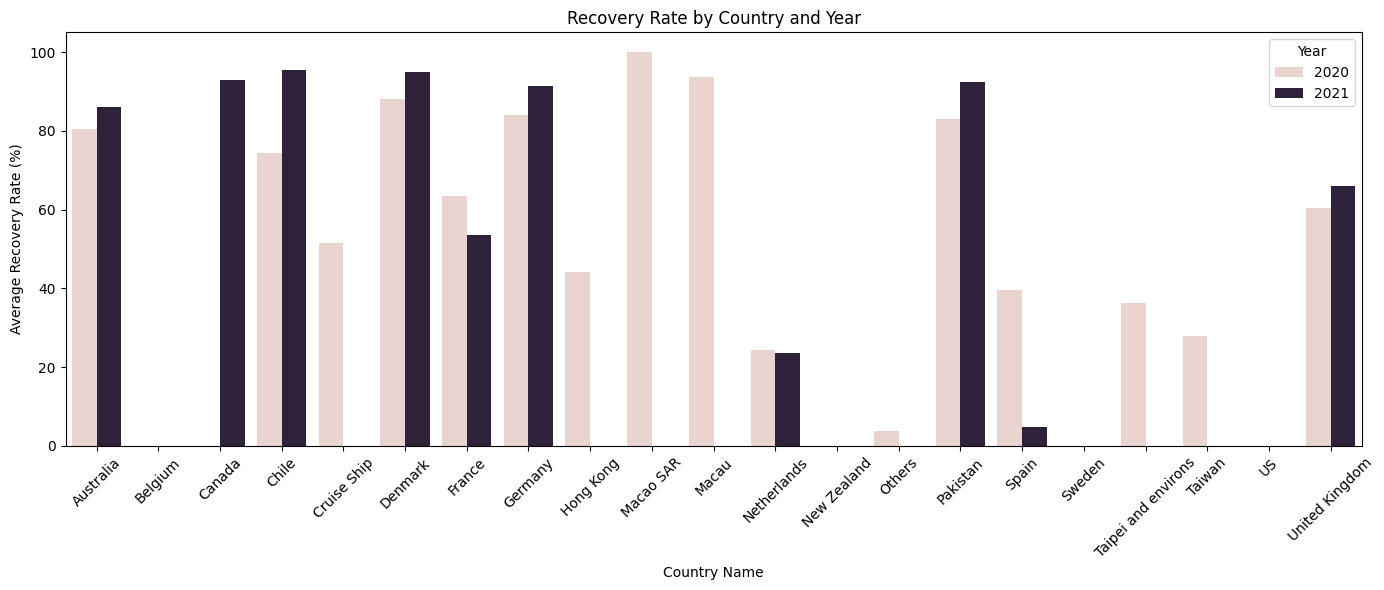

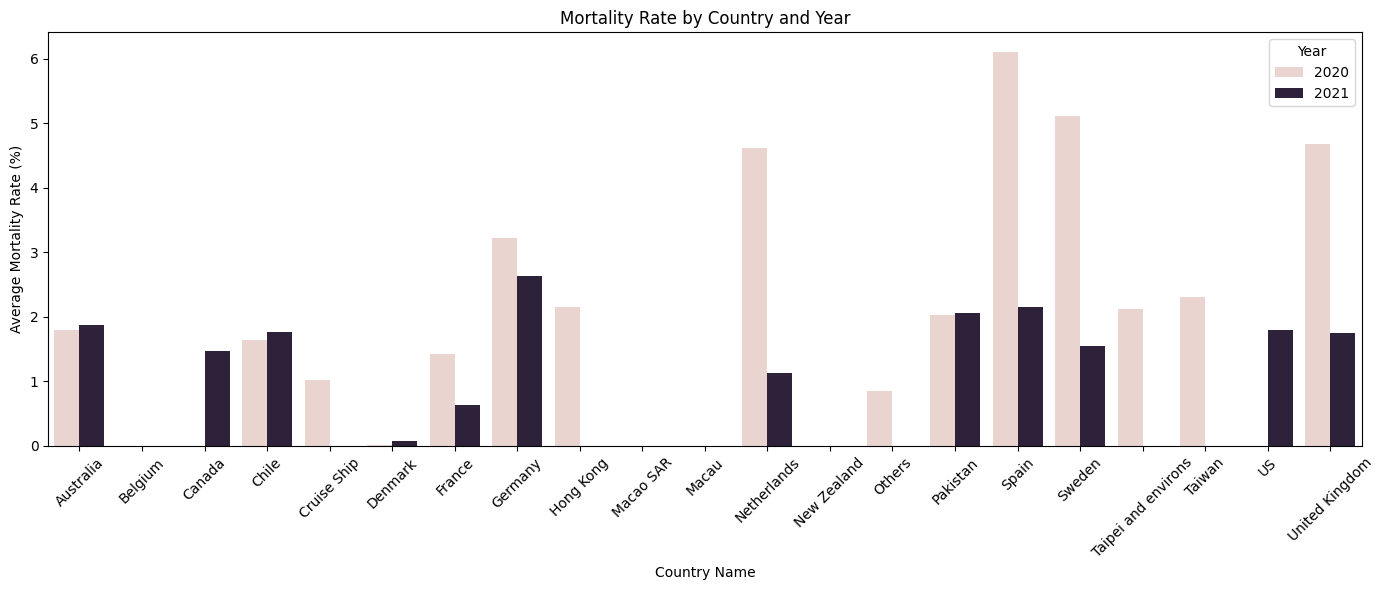

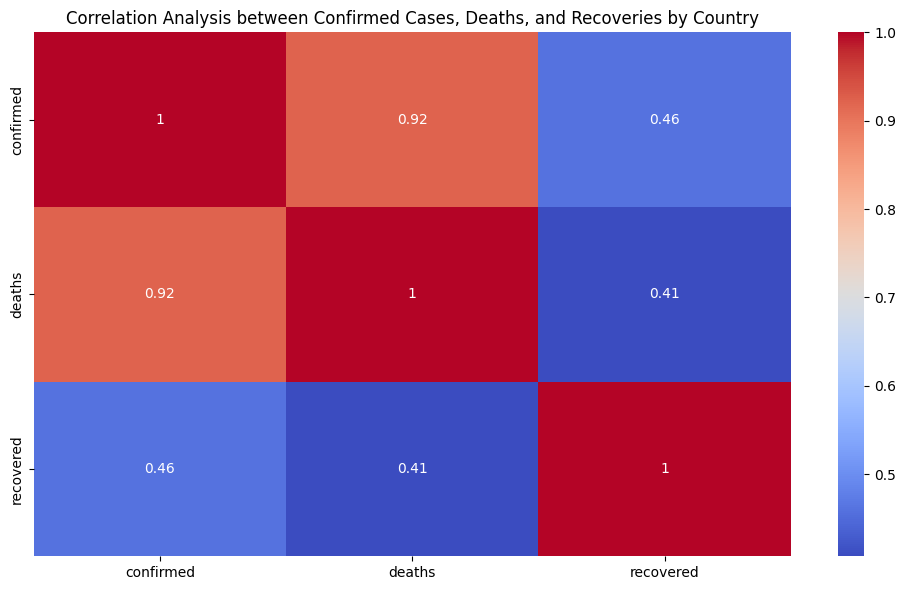

In [ ]:
# Calculate recovery rates and mortality rates for each country
pandas_df['recovery_rate'] = (pandas_df['recovered'] / pandas_df['confirmed']) * 100
pandas_df['mortality_rate'] = (pandas_df['deaths'] / pandas_df['confirmed']) * 100

# Group and visualize recovery rate and mortality rate by year for each country
recovery_mortality_country_df = pandas_df[pandas_df['year'].isin([2020, 2021])].groupby(['country_name', 'year']).agg({
    'recovery_rate': 'mean',
    'mortality_rate': 'mean'
}).reset_index()

# Bar plot for recovery rate by country
plt.figure(figsize=(14, 6))
sns.barplot(data=recovery_mortality_country_df, x='country_name', y='recovery_rate', hue='year')
plt.title('Recovery Rate by Country and Year')
plt.xlabel('Country Name')
plt.ylabel('Average Recovery Rate (%)')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot for mortality rate by country
plt.figure(figsize=(14, 6))
sns.barplot(data=recovery_mortality_country_df, x='country_name', y='mortality_rate', hue='year')
plt.title('Mortality Rate by Country and Year')
plt.xlabel('Country Name')
plt.ylabel('Average Mortality Rate (%)')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation analysis between confirmed cases, deaths, and recoveries by country
correlation_country_df = pandas_df[['country_name', 'confirmed', 'deaths', 'recovered']].groupby('country_name').agg('mean').corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_country_df, annot=True, cmap='coolwarm')
plt.title('Correlation Analysis between Confirmed Cases, Deaths, and Recoveries by Country')
plt.tight_layout()
plt.show()


The first 10 countries with the highest mortality rate per year

<ipython-input-31-8bd3b58e7941>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['mortality_rate'] = pandas_df['deaths'] / pandas_df['confirmed']


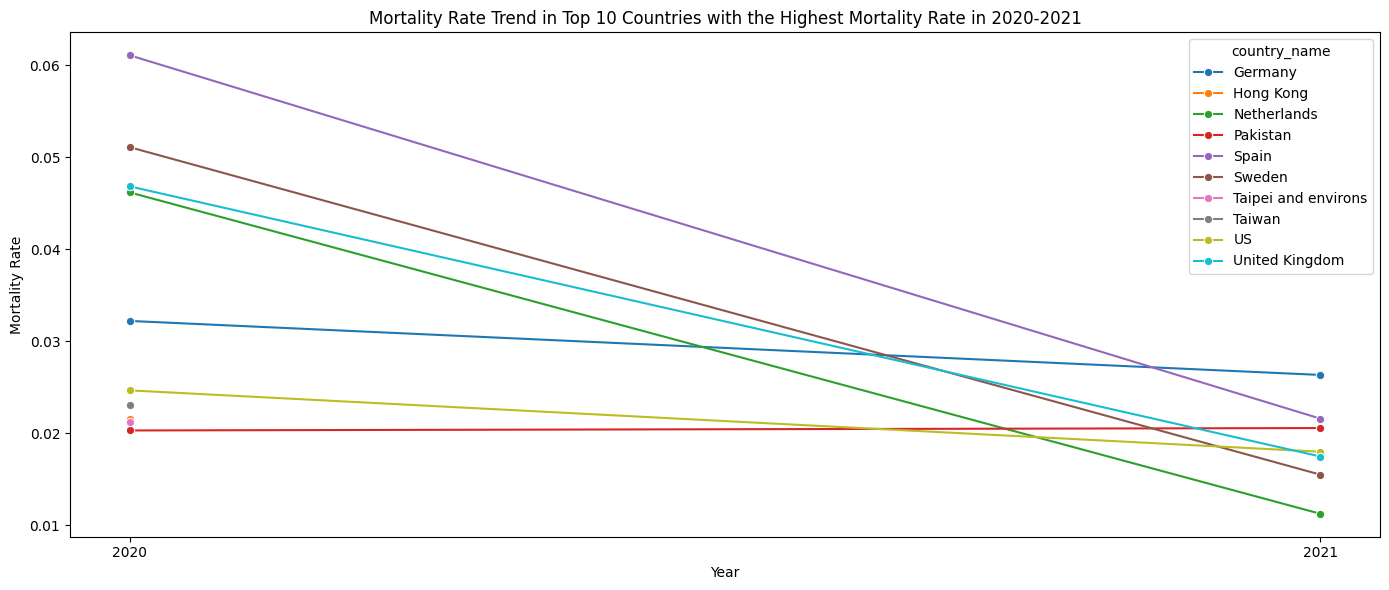

In [ ]:
# Mortality rate by country
pandas_df['mortality_rate'] = pandas_df['deaths'] / pandas_df['confirmed']
mortality_rate_country_df = pandas_df[pandas_df['year'].isin([2020, 2021])].groupby(['country_name', 'year']).agg({'mortality_rate': 'mean'}).reset_index()

# Filter rows with confirmed cases equal to zero to avoid division by zero
pandas_df = pandas_df[pandas_df['confirmed'] > 0]

# Recalculate the mortality rate
pandas_df['mortality_rate'] = pandas_df['deaths'] / pandas_df['confirmed']

# Group by country and year, and calculate the average mortality rate
mortality_rate_country_df = pandas_df[pandas_df['year'].isin([2020, 2021])].groupby(['country_name', 'year']).agg({'mortality_rate': 'mean'}).reset_index()

# Select the top 10 countries with the highest average mortality rate
top_10_countries = mortality_rate_country_df.groupby('country_name')['mortality_rate'].mean().nlargest(10).index
mortality_rate_country_df = mortality_rate_country_df[mortality_rate_country_df['country_name'].isin(top_10_countries)]

# Plot the mortality rate for the top 10 countries
plt.figure(figsize=(14, 6))
sns.lineplot(data=mortality_rate_country_df, x='year', y='mortality_rate', hue='country_name', marker='o')
plt.xticks(ticks=[2020, 2021], labels=[2020, 2021])
plt.title('Mortality Rate Trend in Top 10 Countries with the Highest Mortality Rate in 2020-2021')
plt.xlabel('Year')
plt.ylabel('Mortality Rate')
plt.tight_layout()
plt.show()


MORTALITY RATE and RECOVERY by STATES

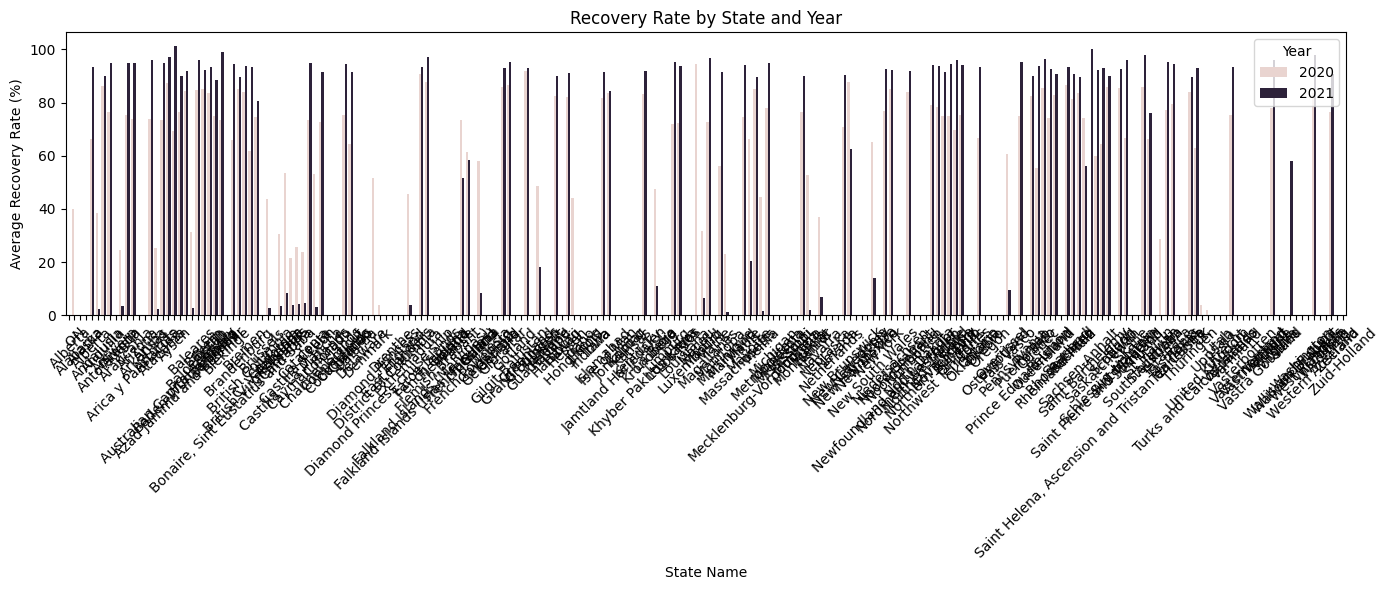

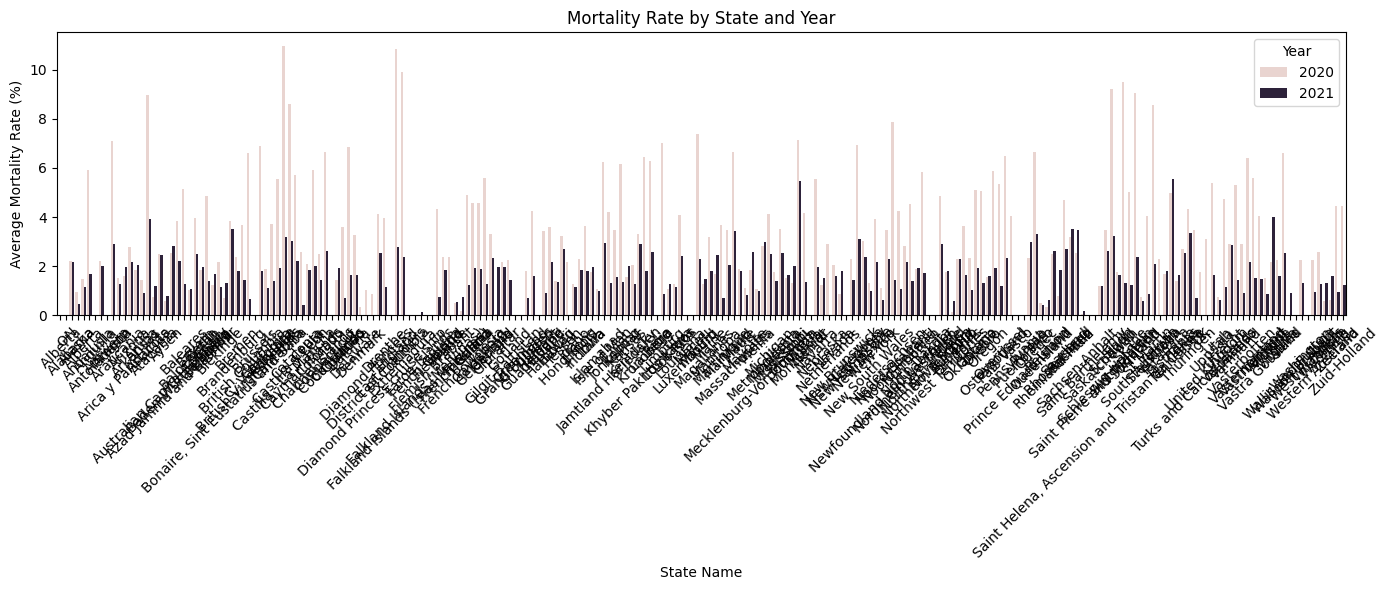

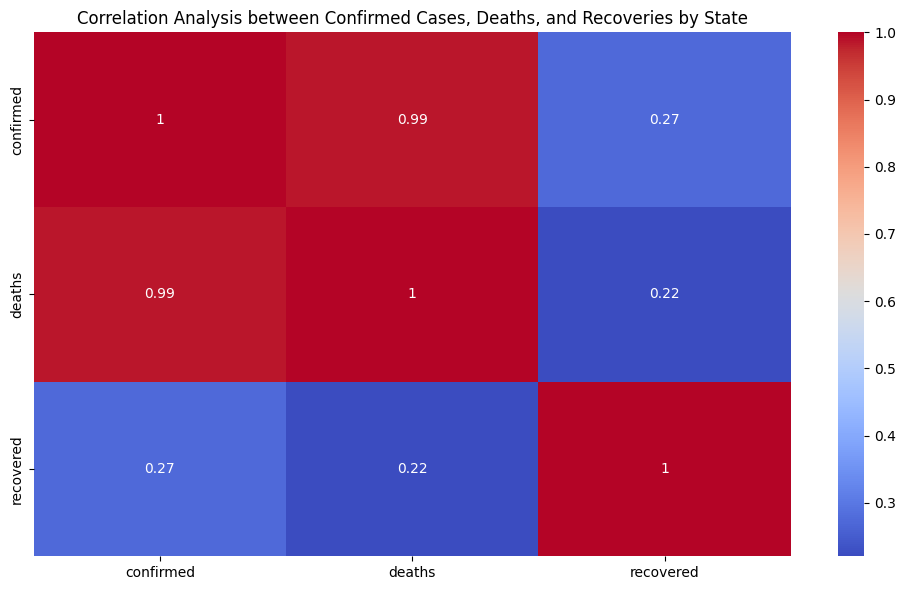

In [ ]:
# Calculate recovery and mortality rates for each state
pandas_df['recovery_rate'] = (pandas_df['recovered'] / pandas_df['confirmed']) * 100
pandas_df['mortality_rate'] = (pandas_df['deaths'] / pandas_df['confirmed']) * 100

# Group by state and year, and calculate the average recovery rate and mortality rate
recovery_mortality_state_df = pandas_df[pandas_df['year'].isin([2020, 2021])].groupby(['state_name', 'year']).agg({
    'recovery_rate': 'mean',
    'mortality_rate': 'mean'
}).reset_index()

# Bar plot for recovery rate by state
plt.figure(figsize=(14, 6))
sns.barplot(data=recovery_mortality_state_df, x='state_name', y='recovery_rate', hue='year')
plt.title('Recovery Rate by State and Year')
plt.xlabel('State Name')
plt.ylabel('Average Recovery Rate (%)')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot for mortality rate by state
plt.figure(figsize=(14, 6))
sns.barplot(data=recovery_mortality_state_df, x='state_name', y='mortality_rate', hue='year')
plt.title('Mortality Rate by State and Year')
plt.xlabel('State Name')
plt.ylabel('Average Mortality Rate (%)')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation analysis between confirmed cases, deaths, and recoveries at the state level
correlation_state_df = pandas_df[['state_name', 'confirmed', 'deaths', 'recovered']].groupby('state_name').agg('mean').corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_state_df, annot=True, cmap='coolwarm')
plt.title('Correlation Analysis between Confirmed Cases, Deaths, and Recoveries by State')
plt.tight_layout()
plt.show()


The first 10 states with the highest mortality rate per year

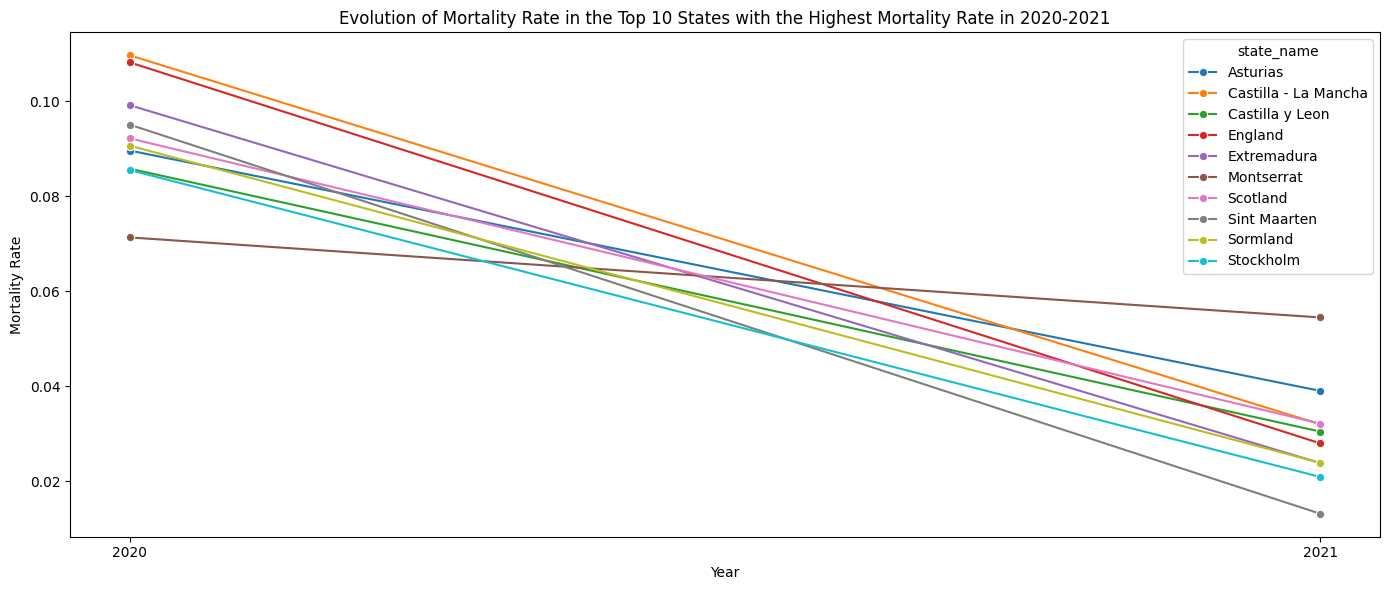

In [ ]:
# Mortality rate by state
pandas_df['mortality_rate'] = pandas_df['deaths'] / pandas_df['confirmed']

# Filter out rows with zero confirmed cases to avoid division by zero
pandas_df = pandas_df[pandas_df['confirmed'] > 0]

# Group by state and year, and calculate the average mortality rate
mortality_rate_state_df = pandas_df[pandas_df['year'].isin([2020, 2021])].groupby(['state_name', 'year']).agg({'mortality_rate': 'mean'}).reset_index()

# Select the top 10 states with the highest average mortality rate
top_10_states = mortality_rate_state_df.groupby('state_name')['mortality_rate'].mean().nlargest(10).index
mortality_rate_state_df = mortality_rate_state_df[mortality_rate_state_df['state_name'].isin(top_10_states)]

# Plot the mortality rate for the top 10 states
plt.figure(figsize=(14, 6))
sns.lineplot(data=mortality_rate_state_df, x='year', y='mortality_rate', hue='state_name', marker='o')
plt.xticks(ticks=[2020, 2021], labels=[2020, 2021])
plt.title('Evolution of Mortality Rate in the Top 10 States with the Highest Mortality Rate in 2020-2021')
plt.xlabel('Year')
plt.ylabel('Mortality Rate')
plt.tight_layout()
plt.show()


The evolution of confirmed cases for the 5 most affected countries

<ipython-input-34-ee87e8b5f0aa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df_top_5['rolling_avg_confirmed'] = pandas_df_top_5.groupby('country_name')['confirmed'].transform(lambda x: x.rolling(window=7).mean())


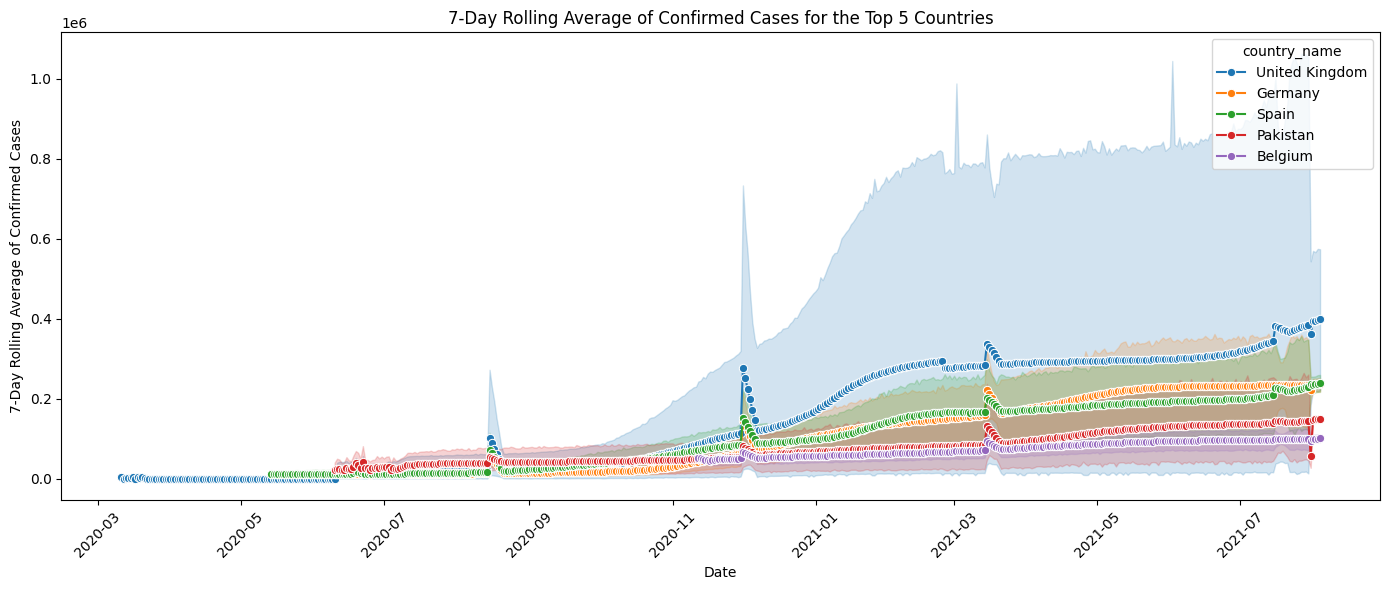

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select the top 5 countries with the highest average confirmed cases
top_5_countries_rolling_avg = pandas_df.groupby('country_name')['confirmed'].mean().nlargest(5).index
pandas_df_top_5 = pandas_df[pandas_df['country_name'].isin(top_5_countries_rolling_avg)]

# Calculate the 7-day rolling average for confirmed cases
pandas_df_top_5['rolling_avg_confirmed'] = pandas_df_top_5.groupby('country_name')['confirmed'].transform(lambda x: x.rolling(window=7).mean())

# Sort the data by refresh_date
pandas_df_top_5 = pandas_df_top_5.sort_values(by='refresh_date')

# Create the plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=pandas_df_top_5, x='refresh_date', y='rolling_avg_confirmed', hue='country_name', marker='o', palette='tab10')
plt.title('7-Day Rolling Average of Confirmed Cases for the Top 5 Countries')
plt.xlabel('Date')
plt.ylabel('7-Day Rolling Average of Confirmed Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, DateType

# Replace null values in numeric columns with 0
numeric_cols = [
    "confirmed", "deaths", "recovered"
]
spark_df = spark_df.fillna(0, subset=numeric_cols)

# Convert the 'refresh_date' column to DateType
spark_df = spark_df.withColumn("refresh_date", F.to_date(F.col("refresh_date"), "yyyy-MM-dd"))

# Convert numeric columns to IntegerType
for col_name in numeric_cols:
    spark_df = spark_df.withColumn(col_name, F.col(col_name).cast(IntegerType()))

# Extract the year and month from the 'refresh_date' column
spark_df = spark_df.withColumn("year", F.year(F.col("refresh_date")))
spark_df = spark_df.withColumn("month", F.month(F.col("refresh_date")))

# Filter out negative values from the critical columns
spark_df = spark_df.filter(
    (F.col("confirmed") >= 0) &
    (F.col("deaths") >= 0) &
    (F.col("recovered") >= 0)
)

# Remove duplicates based on the 'refresh_date', 'country_name', 'state_name' columns
spark_df = spark_df.dropDuplicates(["refresh_date", "country_name", "state_name"])

# Example: Aggregate data by month and 'country_name'
monthly_df = spark_df.groupBy("country_name", "year", "month").agg(
    F.sum("confirmed").alias("monthly_confirmed"),
    F.sum("deaths").alias("monthly_deaths"),
    F.sum("recovered").alias("monthly_recovered")
)

spark_df.show()  # Display the preprocessed data
monthly_df.show()  # Display the aggregated data


+------------+--------------+----------+---------+------+---------+----+-----+---+
|refresh_date|  country_name|state_name|confirmed|deaths|recovered|year|month|day|
+------------+--------------+----------+---------+------+---------+----+-----+---+
|  2020-03-08|         Macau|     Macau|       10|     0|       10|2020|    3|  8|
|  2020-08-08|         Chile|     Maule|     9755|   204|     8724|2020|    8|  8|
|  2020-06-30|      Pakistan|     Sindh|    84640|  1377|    46824|2020|    6| 30|
|  2020-06-17|        Sweden|     Skane|     2437|   224|        0|2020|    6| 17|
|  2020-07-27|         Spain|    Aragon|     9772|   915|     3772|2020|    7| 27|
|  2020-05-26|        Canada|   Alberta|     6901|   139|     6048|2020|    5| 26|
|  2020-07-01|   Netherlands|   Curacao|       23|     1|       19|2020|    7|  1|
|  2020-06-22|United Kingdom|   England|   159118| 38152|        0|2020|    6| 22|
|  2020-05-03|        France|   Mayotte|      650|     6|      235|2020|    5|  3|
|  2

PREDICTIONS based on confirmed cases and recoveries - mortality prediction

LINEAR REGRESSION

In [ ]:
# Import essential libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import patches
from pyspark.sql import functions as F

# Select the relevant columns for prediction
feature_columns_mortality = [
    "confirmed",  # The number of confirmed cases
    "recovered"   # The number of recoveries
]

# Assemble the features into a vector
assembler_mortality = VectorAssembler(inputCols=feature_columns_mortality, outputCol="features")
mortality_df = assembler_mortality.transform(spark_df).select("features", F.col("deaths").alias("label"))

# Split the data into training and testing sets
train_data_mortality, test_data_mortality = mortality_df.randomSplit([0.8, 0.2], seed=42)

# Initialize the linear regression model for mortality prediction
lr_mortality = LinearRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.05, elasticNetParam=0.5)

# Train the linear regression model
lr_model_mortality = lr_mortality.fit(train_data_mortality)

# Make predictions on the testing set
predictions_mortality = lr_model_mortality.transform(test_data_mortality)

# Evaluate the linear regression model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_mortality)
r2 = lr_model_mortality.summary.r2

print(f"Linear Regression - RMSE: {rmse}")
print(f"Linear Regression - R2: {r2}")


Linear Regression - RMSE: 1547.9301098117799
Linear Regression - R2: 0.9199900271695856


<ipython-input-37-302cb222eb7e>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


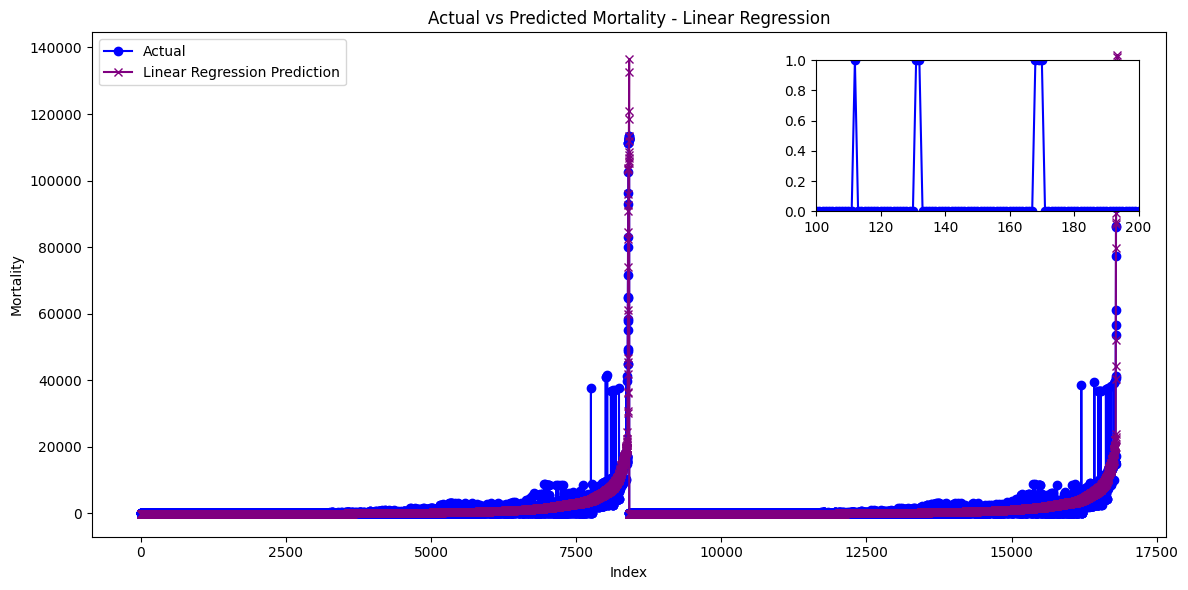

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Convert to Pandas DataFrame for plotting
predictions_lr_pd = predictions_mortality.select("label", "prediction").toPandas()

# Plot for Linear Regression
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(predictions_lr_pd.index, predictions_lr_pd['label'], label='Actual', color='blue', linestyle='-', marker='o')
ax.plot(predictions_lr_pd.index, predictions_lr_pd['prediction'], label='Linear Regression Prediction', color='purple', linestyle='-', marker='x')

ax.set_xlabel('Index')
ax.set_ylabel('Mortality')
ax.set_title('Actual vs Predicted Mortality - Linear Regression')
ax.legend()

# Adding a secondary axis for detail
axins = inset_axes(ax, width="30%", height="30%", loc='upper right', borderpad=2)
x1, x2 = 100, 200
y1, y2 = predictions_lr_pd['label'][x1:x2].min(), predictions_lr_pd['label'][x1:x2].max()
axins.plot(predictions_lr_pd.index, predictions_lr_pd['label'], color='blue', linestyle='-', marker='o')
axins.plot(predictions_lr_pd.index, predictions_lr_pd['prediction'], color='purple', linestyle='-', marker='x')

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='gray', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(rectangle)

plt.tight_layout()
plt.show()


GRADIENT BOOSTED TREES

In [ ]:
# Initialize the Gradient Boosted Tree model for death prediction
gbt_mortality = GBTRegressor(featuresCol="features", labelCol="label", maxIter=50, maxDepth=5, seed=42)

# Train the Gradient Boosted Tree model
gbt_model_mortality = gbt_mortality.fit(train_data_mortality)

# Make predictions on the test set
predictions_mortality_gbt = gbt_model_mortality.transform(test_data_mortality).withColumnRenamed("prediction", "GBT")

# Evaluate the Gradient Boosted Tree model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="GBT", metricName="rmse")
rmse_gbt = evaluator.evaluate(predictions_mortality_gbt)
print(f"Gradient Boosted Trees - RMSE: {rmse_gbt}")

r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="GBT", metricName="r2")
r2_gbt = r2_evaluator.evaluate(predictions_mortality_gbt)
print(f"Gradient Boosted Trees - R2: {r2_gbt}")


Gradient Boosted Trees - RMSE: 2041.994416892177
Gradient Boosted Trees - R2: 0.8985153251940968


<ipython-input-39-182f572259d3>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


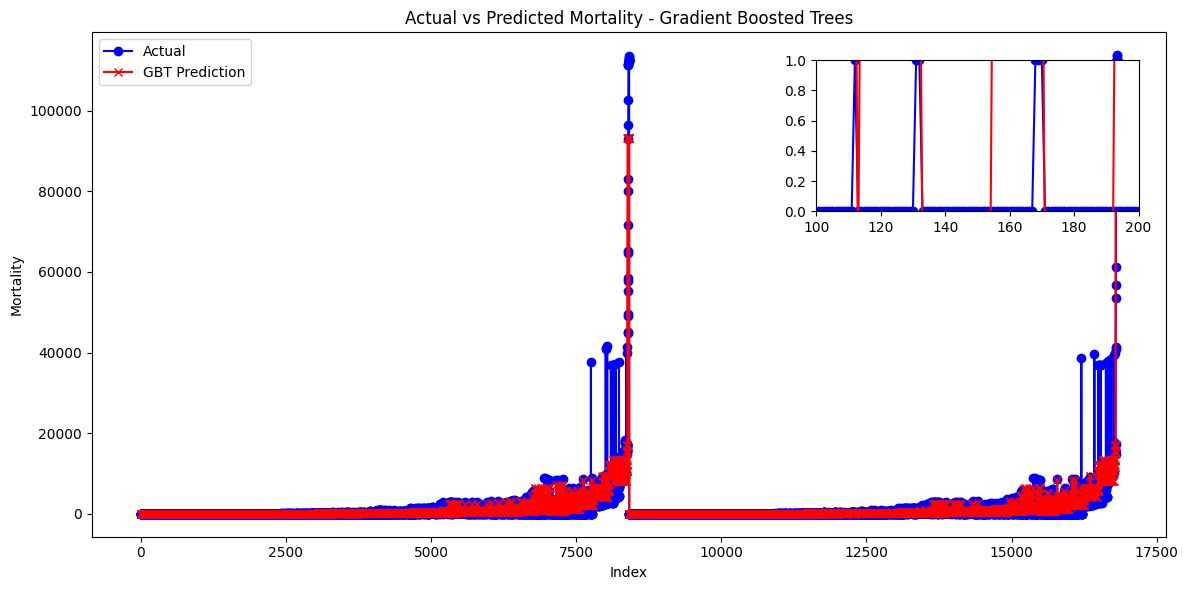

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Convert to Pandas DataFrame for plotting
predictions_gbt_pd = predictions_mortality_gbt.select("label", "GBT").toPandas()

# Plot for Gradient Boosted Trees
fig, ax = plt.subplots(figsize=(12, 6))

# Actual values (label)
ax.plot(predictions_gbt_pd.index, predictions_gbt_pd['label'], label='Actual', color='blue', linestyle='-', marker='o')

# Gradient Boosted Trees model predictions (GBT)
ax.plot(predictions_gbt_pd.index, predictions_gbt_pd['GBT'], label='GBT Prediction', color='red', linestyle='-', marker='x')

ax.set_xlabel('Index')
ax.set_ylabel('Mortality')
ax.set_title('Actual vs Predicted Mortality - Gradient Boosted Trees')
ax.legend()

# Adding a secondary inset axis for zoom detail
axins = inset_axes(ax, width="30%", height="30%", loc='upper right', borderpad=2)
x1, x2 = 100, 200  # Defining the range for zoom
y1, y2 = predictions_gbt_pd['label'][x1:x2].min(), predictions_gbt_pd['label'][x1:x2].max()
axins.plot(predictions_gbt_pd.index, predictions_gbt_pd['label'], color='blue', linestyle='-', marker='o')
axins.plot(predictions_gbt_pd.index, predictions_gbt_pd['GBT'], color='red', linestyle='-', marker='x')

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Creating a rectangle to highlight the area of interest
rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='gray', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(rectangle)

plt.tight_layout()
plt.show()


RANDOM FOREST

In [ ]:
# Initialize the Random Forest model for mortality prediction
rf_mortality = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=50, seed=42)

# Train the Random Forest model
rf_model_mortality = rf_mortality.fit(train_data_mortality)

# Make predictions on the test set
predictions_mortality_rf = rf_model_mortality.transform(test_data_mortality).withColumnRenamed("prediction", "RandomForest")

# Evaluate the Random Forest model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="RandomForest", metricName="rmse")
rmse_rf = evaluator.evaluate(predictions_mortality_rf)
print(f"Random Forest - RMSE: {rmse_rf}")

r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="RandomForest", metricName="r2")
r2_rf = r2_evaluator.evaluate(predictions_mortality_rf)
print(f"Random Forest - R2: {r2_rf}")


Random Forest - RMSE: 2314.272702191011
Random Forest - R2: 0.869647180540774


<ipython-input-41-8847ef16cfad>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


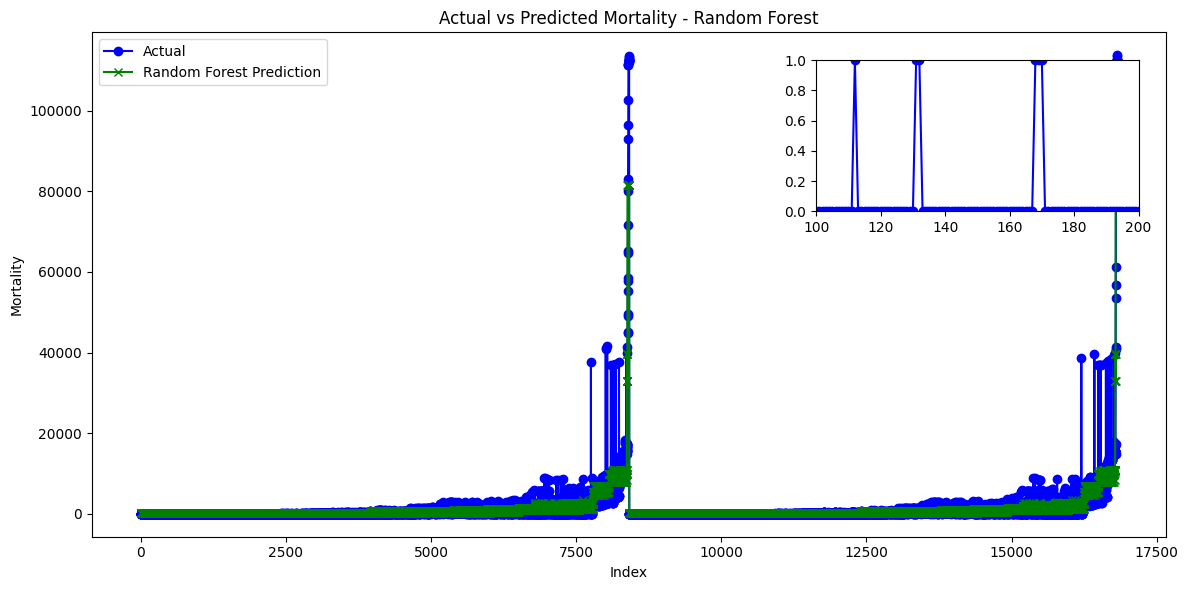

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Convert to Pandas DataFrame for plotting
predictions_rf_pd = predictions_mortality_rf.select("label", "RandomForest").toPandas()

# Plot for Random Forest
fig, ax = plt.subplots(figsize=(12, 6))

# Actual values (label)
ax.plot(predictions_rf_pd.index, predictions_rf_pd['label'], label='Actual', color='blue', linestyle='-', marker='o')

# Predictions from the Random Forest model
ax.plot(predictions_rf_pd.index, predictions_rf_pd['RandomForest'], label='Random Forest Prediction', color='green', linestyle='-', marker='x')

ax.set_xlabel('Index')
ax.set_ylabel('Mortality')
ax.set_title('Actual vs Predicted Mortality - Random Forest')
ax.legend()

# Add a secondary axis for zooming in
axins = inset_axes(ax, width="30%", height="30%", loc='upper right', borderpad=2)
x1, x2 = 100, 200  # Define the range of data for zoom
y1, y2 = predictions_rf_pd['label'][x1:x2].min(), predictions_rf_pd['label'][x1:x2].max()
axins.plot(predictions_rf_pd.index, predictions_rf_pd['label'], color='blue', linestyle='-', marker='o')
axins.plot(predictions_rf_pd.index, predictions_rf_pd['RandomForest'], color='green', linestyle='-', marker='x')

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Create a rectangle to highlight the area of interest
rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='gray', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(rectangle)

plt.tight_layout()
plt.show()


ELASTIC NET

In [ ]:
# Initialize the Elastic Net model for death prediction
elastic_net = LinearRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.1, elasticNetParam=0.5)

# Train the Elastic Net model
elastic_net_model = elastic_net.fit(train_data_mortality)

# Make predictions on the test set
predictions_mortality_en = elastic_net_model.transform(test_data_mortality).withColumnRenamed("prediction", "ElasticNet")

# Evaluate the Elastic Net model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="ElasticNet", metricName="rmse")
rmse_en = evaluator.evaluate(predictions_mortality_en)
print(f"Elastic Net - RMSE: {rmse_en}")

r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="ElasticNet", metricName="r2")
r2_en = r2_evaluator.evaluate(predictions_mortality_en)
print(f"Elastic Net - R2: {r2_en}")


Elastic Net - RMSE: 1547.9295611926711
Elastic Net - R2: 0.941683191002433


<ipython-input-43-e194eef3f809>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


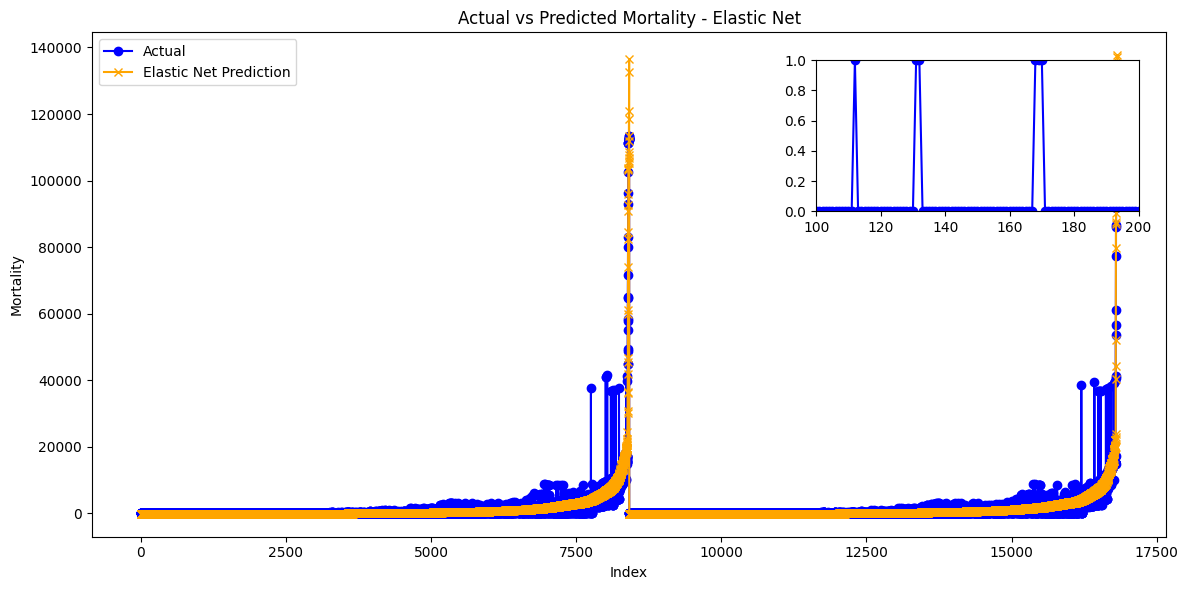

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Convert to Pandas DataFrame for plotting
predictions_en_pd = predictions_mortality_en.select("label", "ElasticNet").toPandas()

# Plot for Elastic Net
fig, ax = plt.subplots(figsize=(12, 6))

# Actual values (label)
ax.plot(predictions_en_pd.index, predictions_en_pd['label'], label='Actual', color='blue', linestyle='-', marker='o')

# Predictions of the Elastic Net model
ax.plot(predictions_en_pd.index, predictions_en_pd['ElasticNet'], label='Elastic Net Prediction', color='orange', linestyle='-', marker='x')

ax.set_xlabel('Index')
ax.set_ylabel('Mortality')
ax.set_title('Actual vs Predicted Mortality - Elastic Net')
ax.legend()

# Add a secondary axis for zoom detail
axins = inset_axes(ax, width="30%", height="30%", loc='upper right', borderpad=2)
x1, x2 = 100, 200  # Define the data range for zoom
y1, y2 = predictions_en_pd['label'][x1:x2].min(), predictions_en_pd['label'][x1:x2].max()
axins.plot(predictions_en_pd.index, predictions_en_pd['label'], color='blue', linestyle='-', marker='o')
axins.plot(predictions_en_pd.index, predictions_en_pd['ElasticNet'], color='orange', linestyle='-', marker='x')

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Create a rectangle to highlight the area of interest
rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='gray', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(rectangle)

plt.tight_layout()
plt.show()


DECISION TREE REGRESSOR

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

# Initialize the Decision Tree model for mortality prediction
dt_mortality = DecisionTreeRegressor(featuresCol="features", labelCol="label", maxDepth=5)

# Train the Decision Tree model
dt_model_mortality = dt_mortality.fit(train_data_mortality)

# Make predictions on the test set
predictions_mortality_dt = dt_model_mortality.transform(test_data_mortality).withColumnRenamed("prediction", "DecisionTree")

# Evaluate the Decision Tree model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="DecisionTree", metricName="rmse")
rmse_dt = evaluator.evaluate(predictions_mortality_dt)
print(f"Decision Tree - RMSE: {rmse_dt}")

r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="DecisionTree", metricName="r2")
r2_dt = r2_evaluator.evaluate(predictions_mortality_dt)
print(f"Decision Tree - R2: {r2_dt}")


Decision Tree - RMSE: 2001.4459475368815
Decision Tree - R2: 0.9025057292282145


<ipython-input-45-038746dbbc7b>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


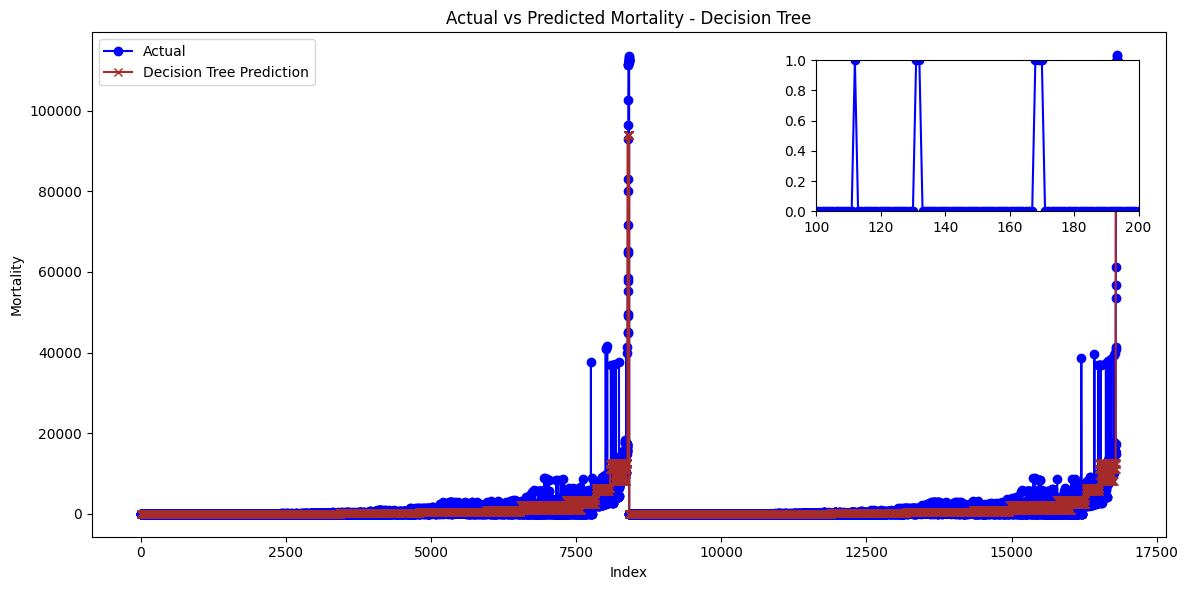

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Convert to Pandas DataFrame for plotting
predictions_dt_pd = predictions_mortality_dt.select("label", "DecisionTree").toPandas()

# Plot for Decision Tree
fig, ax = plt.subplots(figsize=(12, 6))

# Actual values (label)
ax.plot(predictions_dt_pd.index, predictions_dt_pd['label'], label='Actual', color='blue', linestyle='-', marker='o')

# Predictions from the Decision Tree model
ax.plot(predictions_dt_pd.index, predictions_dt_pd['DecisionTree'], label='Decision Tree Prediction', color='brown', linestyle='-', marker='x')

ax.set_xlabel('Index')
ax.set_ylabel('Mortality')
ax.set_title('Actual vs Predicted Mortality - Decision Tree')
ax.legend()

# Adding a secondary axis for zoomed-in view
axins = inset_axes(ax, width="30%", height="30%", loc='upper right', borderpad=2)
x1, x2 = 100, 200  # Define the data range for zoom
y1, y2 = predictions_dt_pd['label'][x1:x2].min(), predictions_dt_pd['label'][x1:x2].max()
axins.plot(predictions_dt_pd.index, predictions_dt_pd['label'], color='blue', linestyle='-', marker='o')
axins.plot(predictions_dt_pd.index, predictions_dt_pd['DecisionTree'], color='brown', linestyle='-', marker='x')

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Creating a rectangle to mark the region of interest
rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='gray', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(rectangle)

plt.tight_layout()
plt.show()


LASSO REGRESSION

In [ ]:
# Initialize the Lasso Regression model for death prediction
lasso_mortality = LinearRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.1, elasticNetParam=1.0)

# Train the Lasso Regression model
lasso_model_mortality = lasso_mortality.fit(train_data_mortality)

# Make predictions on the test set
predictions_mortality_lasso = lasso_model_mortality.transform(test_data_mortality).withColumnRenamed("prediction", "Lasso")

# Evaluate the Lasso Regression model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="Lasso", metricName="rmse")
rmse_lasso = evaluator.evaluate(predictions_mortality_lasso)
print(f"Lasso Regression - RMSE: {rmse_lasso}")

r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="Lasso", metricName="r2")
r2_lasso = r2_evaluator.evaluate(predictions_mortality_lasso)
print(f"Lasso Regression - R2: {r2_lasso}")


Lasso Regression - RMSE: 1547.9296413450647
Lasso Regression - R2: 0.9416831849630989


<ipython-input-47-20bb0e84a457>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


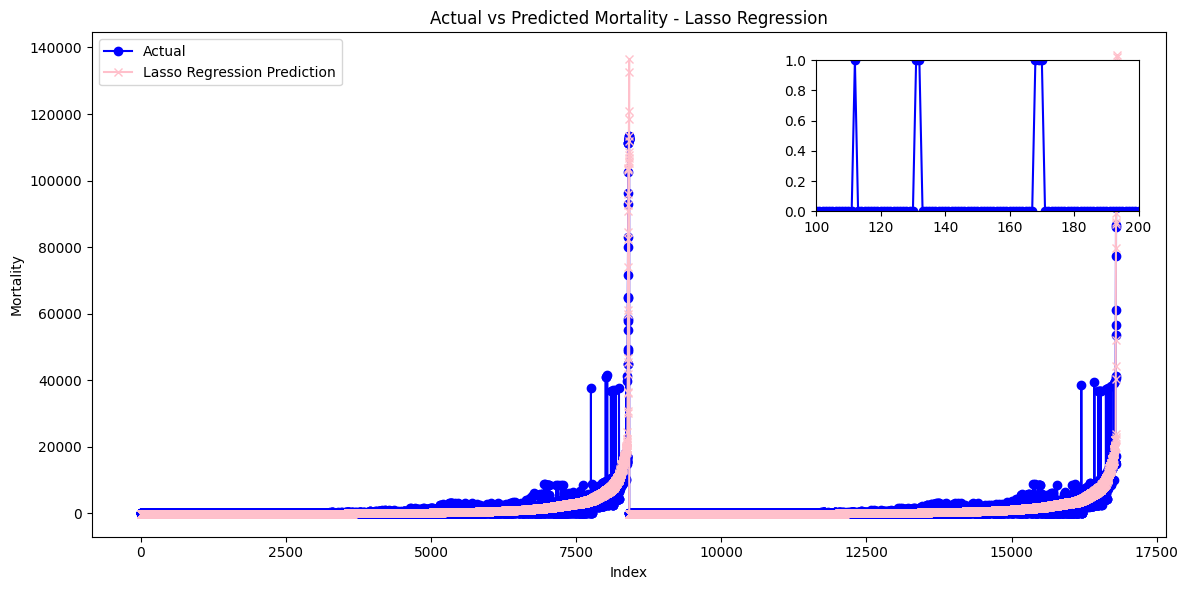

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Convert to Pandas DataFrame for plotting
predictions_lasso_pd = predictions_mortality_lasso.select("label", "Lasso").toPandas()

# Plot for Lasso Regression
fig, ax = plt.subplots(figsize=(12, 6))

# Actual values (label)
ax.plot(predictions_lasso_pd.index, predictions_lasso_pd['label'], label='Actual', color='blue', linestyle='-', marker='o')

# Lasso Regression predictions (now with pink color)
ax.plot(predictions_lasso_pd.index, predictions_lasso_pd['Lasso'], label='Lasso Regression Prediction', color='pink', linestyle='-', marker='x')

ax.set_xlabel('Index')
ax.set_ylabel('Mortality')
ax.set_title('Actual vs Predicted Mortality - Lasso Regression')
ax.legend()

# Add secondary axis for detail
axins = inset_axes(ax, width="30%", height="30%", loc='upper right', borderpad=2)
x1, x2 = 100, 200  # Define the data range for zoom
y1, y2 = predictions_lasso_pd['label'][x1:x2].min(), predictions_lasso_pd['label'][x1:x2].max()
axins.plot(predictions_lasso_pd.index, predictions_lasso_pd['label'], color='blue', linestyle='-', marker='o')
axins.plot(predictions_lasso_pd.index, predictions_lasso_pd['Lasso'], color='pink', linestyle='-', marker='x')

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Create a rectangle to highlight the area of interest
rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='gray', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(rectangle)

plt.tight_layout()
plt.show()


SVM

In [ ]:
from pyspark.ml.regression import GeneralizedLinearRegression

# Initialize the SVM model for death prediction
svm_mortality = GeneralizedLinearRegression(featuresCol="features", labelCol="label", family="gaussian", link="identity", regParam=0.1)

# Train the SVM model
svm_model_mortality = svm_mortality.fit(train_data_mortality)

# Make predictions on the test set
predictions_mortality_svm = svm_model_mortality.transform(test_data_mortality).withColumnRenamed("prediction", "SVM")

# Evaluate the SVM model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="SVM", metricName="rmse")
rmse_svm = evaluator.evaluate(predictions_mortality_svm)
print(f"SVM - RMSE: {rmse_svm}")

r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="SVM", metricName="r2")
r2_svm = r2_evaluator.evaluate(predictions_mortality_svm)
print(f"SVM - R2: {r2_svm}")


SVM - RMSE: 1547.9294807888923
SVM - R2: 0.9416831970607084


<ipython-input-49-2e6483f96f3a>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


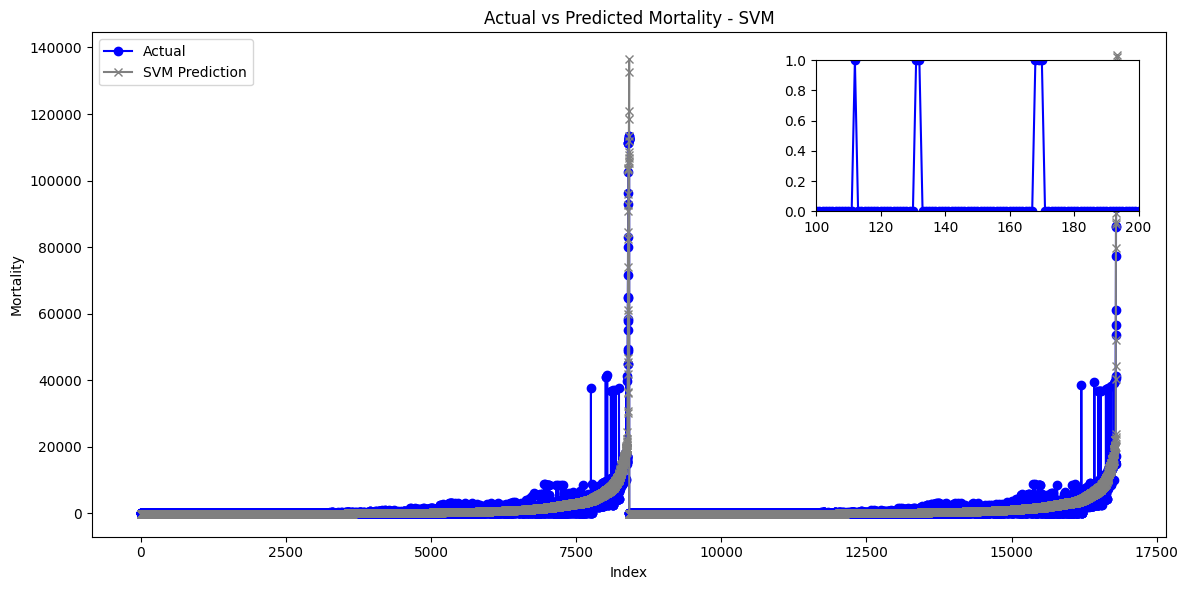

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Convert to Pandas DataFrame for SVM predictions
predictions_svm_pd = predictions_mortality_svm.select("label", "SVM").toPandas()

# Plot for SVM
fig, ax = plt.subplots(figsize=(12, 6))

# Actual values (label)
ax.plot(predictions_svm_pd.index, predictions_svm_pd['label'], label='Actual', color='blue', linestyle='-', marker='o')

# Predictions from the SVM model (now with gray color)
ax.plot(predictions_svm_pd.index, predictions_svm_pd['SVM'], label='SVM Prediction', color='gray', linestyle='-', marker='x')

ax.set_xlabel('Index')
ax.set_ylabel('Mortality')
ax.set_title('Actual vs Predicted Mortality - SVM')
ax.legend()

# Add a secondary axis for zooming (detailed view)
axins = inset_axes(ax, width="30%", height="30%", loc='upper right', borderpad=2)
x1, x2 = 100, 200  # Define the range of data for zooming
y1, y2 = predictions_svm_pd['label'][x1:x2].min(), predictions_svm_pd['label'][x1:x2].max()
axins.plot(predictions_svm_pd.index, predictions_svm_pd['label'], color='blue', linestyle='-', marker='o')
axins.plot(predictions_svm_pd.index, predictions_svm_pd['SVM'], color='gray', linestyle='-', marker='x')

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Create a rectangle to mark the region of interest
rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='gray', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(rectangle)

plt.tight_layout()
plt.show()


The chart with all 7 algorithms


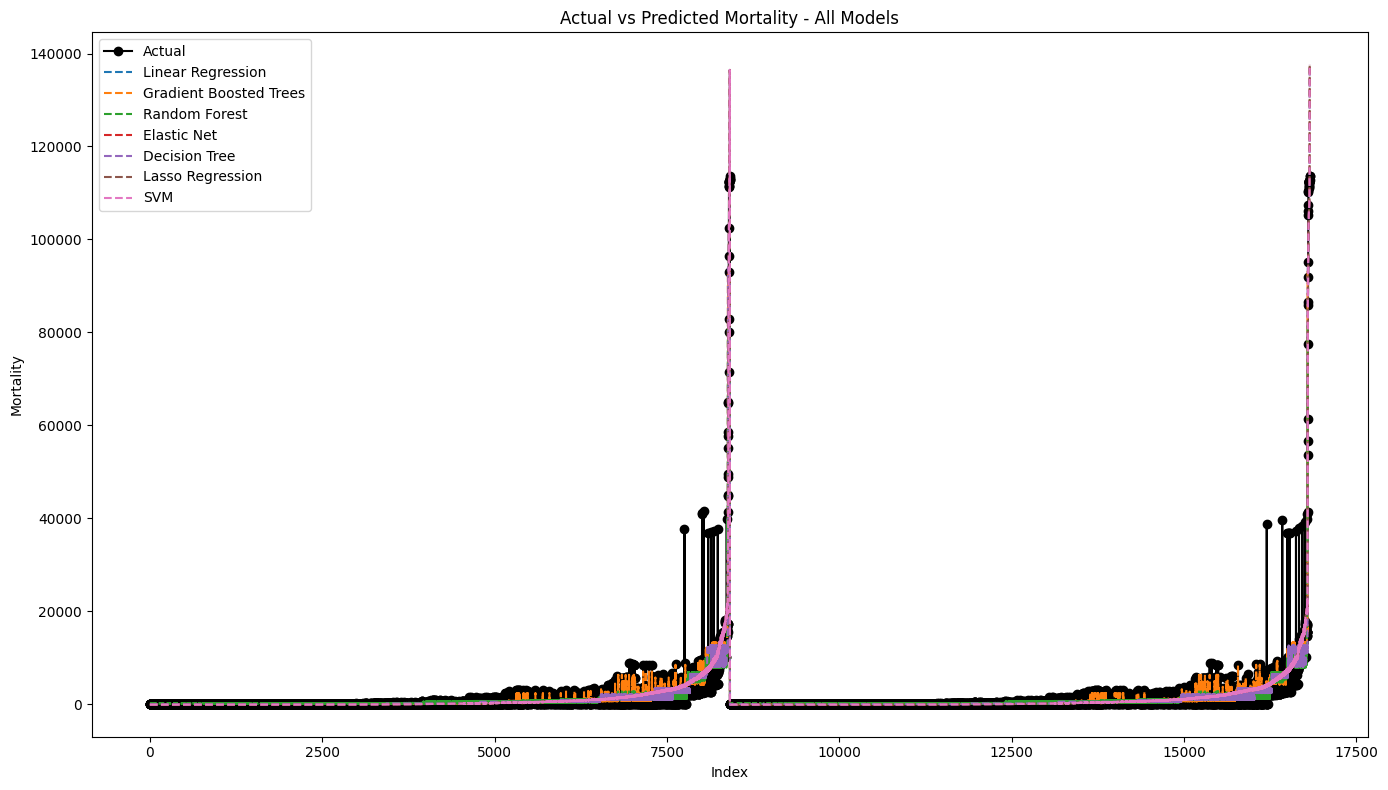

In [ ]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for all models
predictions_lr_pd = predictions_mortality.select("label", "prediction").withColumnRenamed("prediction", "LinearRegression").toPandas()
predictions_gbt_pd = predictions_mortality_gbt.select("label", "GBT").toPandas()
predictions_rf_pd = predictions_mortality_rf.select("label", "RandomForest").toPandas()
predictions_en_pd = predictions_mortality_en.select("label", "ElasticNet").toPandas()
predictions_dt_pd = predictions_mortality_dt.select("label", "DecisionTree").toPandas()
predictions_lasso_pd = predictions_mortality_lasso.select("label", "Lasso").toPandas()
predictions_svm_pd = predictions_mortality_svm.select("label", "SVM").toPandas()

# Combine all DataFrames into one
combined_df = predictions_lr_pd.copy()
combined_df["GBT"] = predictions_gbt_pd["GBT"]
combined_df["RandomForest"] = predictions_rf_pd["RandomForest"]
combined_df["ElasticNet"] = predictions_en_pd["ElasticNet"]
combined_df["DecisionTree"] = predictions_dt_pd["DecisionTree"]
combined_df["Lasso"] = predictions_lasso_pd["Lasso"]
combined_df["SVM"] = predictions_svm_pd["SVM"]

# Combined plot for all models
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(combined_df.index, combined_df['label'], label='Actual', color='black', linestyle='-', marker='o')

# Add predictions from each algorithm
ax.plot(combined_df.index, combined_df['LinearRegression'], label='Linear Regression', linestyle='--')
ax.plot(combined_df.index, combined_df['GBT'], label='Gradient Boosted Trees', linestyle='--')
ax.plot(combined_df.index, combined_df['RandomForest'], label='Random Forest', linestyle='--')
ax.plot(combined_df.index, combined_df['ElasticNet'], label='Elastic Net', linestyle='--')
ax.plot(combined_df.index, combined_df['DecisionTree'], label='Decision Tree', linestyle='--')
ax.plot(combined_df.index, combined_df['Lasso'], label='Lasso Regression', linestyle='--')
ax.plot(combined_df.index, combined_df['SVM'], label='SVM', linestyle='--')

# Set plot settings
ax.set_xlabel('Index')
ax.set_ylabel('Mortality')
ax.set_title('Actual vs Predicted Mortality - All Models')
ax.legend()
plt.tight_layout()
plt.show()


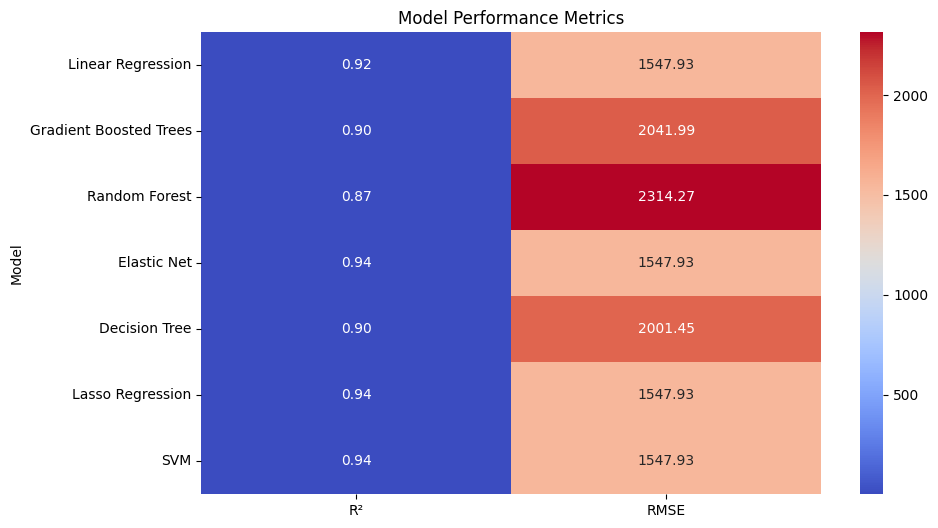

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Evaluation data (replace with previously calculated values)
evaluation_data = {
    "Model": ["Linear Regression", "Gradient Boosted Trees", "Random Forest", "Elastic Net", "Decision Tree", "Lasso Regression", "SVM"],
    "R²": [r2, r2_gbt, r2_rf, r2_en, r2_dt, r2_lasso, r2_svm],
    "RMSE": [rmse, rmse_gbt, rmse_rf, rmse_en, rmse_dt, rmse_lasso, rmse_svm]
}

eval_df = pd.DataFrame(evaluation_data)

# Heatmap for evaluation
plt.figure(figsize=(10, 6))
sns.heatmap(eval_df.set_index("Model"), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Model Performance Metrics")
plt.show()


In [ ]:
import pandas as pd

# R² values already calculated for each model
r2_values = {
    'Model': ['Linear Regression', 'Gradient Boosted Trees', 'Random Forest',
              'Elastic Net', 'Decision Tree', 'Lasso Regression', 'SVM'],
    'R2 Value': [r2, r2_gbt, r2_rf, r2_en, r2_dt, r2_lasso, r2_svm],  # R² values between 0 and 1
    'R2 Value (%)': [r2 * 100, r2_gbt * 100, r2_rf * 100, r2_en * 100,
                     r2_dt * 100, r2_lasso * 100, r2_svm * 100]  # R² as percentages
}

# Creating the DataFrame with Pandas
r2_df = pd.DataFrame(r2_values)

# Display the table with R² values and R² percentages
print(r2_df)


                    Model  R2 Value  R2 Value (%)
0       Linear Regression  0.919990     91.999003
1  Gradient Boosted Trees  0.898515     89.851533
2           Random Forest  0.869647     86.964718
3             Elastic Net  0.941683     94.168319
4           Decision Tree  0.902506     90.250573
5        Lasso Regression  0.941683     94.168318
6                     SVM  0.941683     94.168320


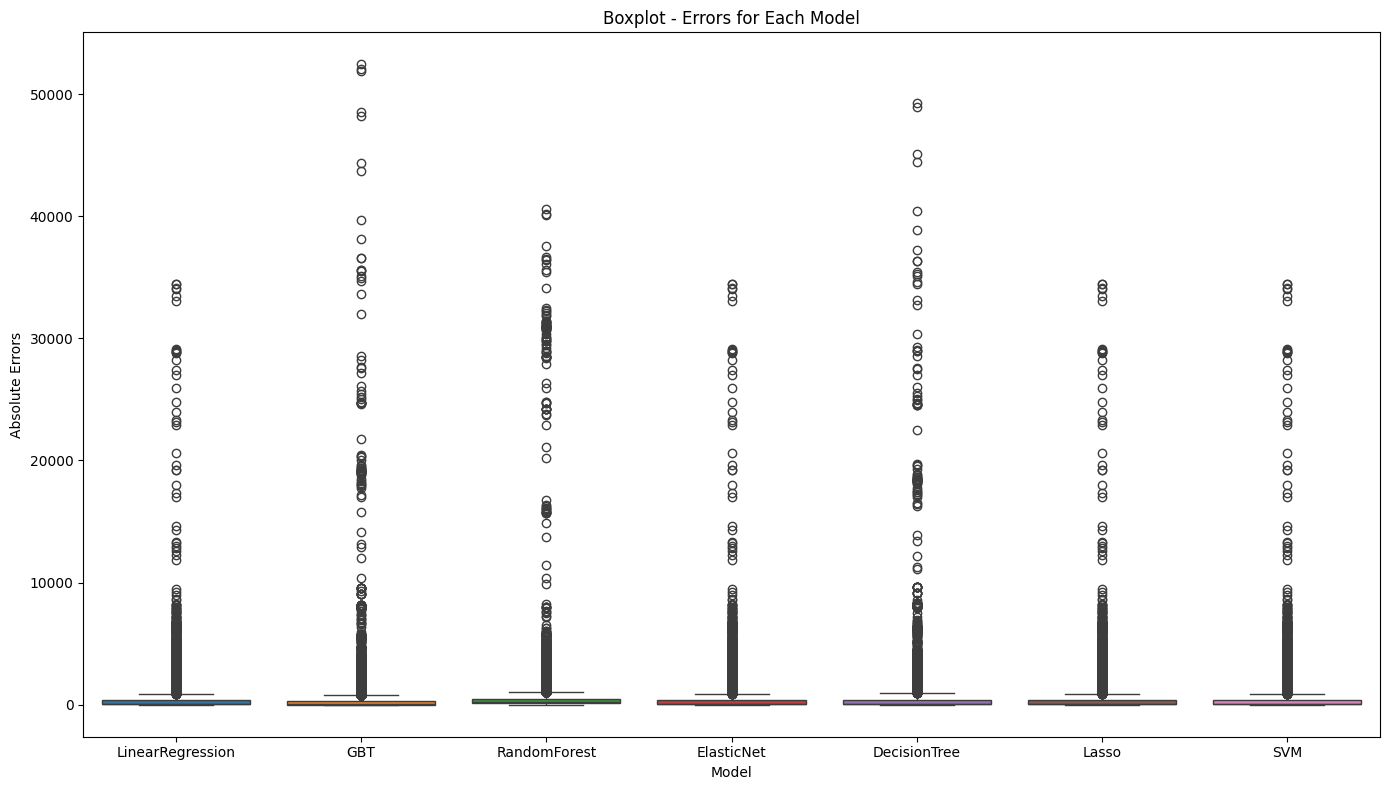

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate the errors for each model
combined_df['LR_error'] = abs(combined_df['label'] - combined_df['LinearRegression'])
combined_df['GBT_error'] = abs(combined_df['label'] - combined_df['GBT'])
combined_df['RF_error'] = abs(combined_df['label'] - combined_df['RandomForest'])
combined_df['EN_error'] = abs(combined_df['label'] - combined_df['ElasticNet'])
combined_df['DT_error'] = abs(combined_df['label'] - combined_df['DecisionTree'])
combined_df['Lasso_error'] = abs(combined_df['label'] - combined_df['Lasso'])
combined_df['SVM_error'] = abs(combined_df['label'] - combined_df['SVM'])

# Combine the errors into a DataFrame for the boxplot
errors_df = pd.DataFrame({
    'LinearRegression': combined_df['LR_error'],
    'GBT': combined_df['GBT_error'],
    'RandomForest': combined_df['RF_error'],
    'ElasticNet': combined_df['EN_error'],
    'DecisionTree': combined_df['DT_error'],
    'Lasso': combined_df['Lasso_error'],
    'SVM': combined_df['SVM_error']
})

# Create the boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=errors_df)

# Set the title and labels
plt.title('Boxplot - Errors for Each Model')
plt.xlabel('Model')
plt.ylabel('Absolute Errors')

# Display the plot
plt.tight_layout()
plt.show()
